# Machine Learning Project : Space Invadors using deep Q reinforcement learning. 

This first snipped of code will import all of the necessary libraries to run this code successfully. We import the environment for Space-Invaders and our agent's "brain" from the file we modified.
 


%matplotlib inline
import matplotlib.pyplot as plt

from ipywidgets import widgets
from IPython.display import display

from matplotlib import animation
from JSAnimation.IPython_display import display_animation
from time import gmtime, strftime
import random
import cv2
import sys
from BrainDQN_Nature3L import *
import numpy as np 

import gym


env = gym.make('SpaceInvaders-v0')
env.reset()
actions = env.action_space.n
brain = BrainDQN3L(actions)

### Image preprocessing

As mentioned in the paper, we have a $210 * 160 * 3 = 100.800$ variables. Since the computer doesn't need 4k graphics to be trained, we trim this down to $65 * 160 * 1$. These dimentions were chosen based on the score board at the top of game, plus the first couple of rows of Space-Invaders that we don't care about seeing plus the ground which also doesn't contribute to the training of our agent. This effectively reduces down the number of variable to : $65 * 160 * 1 = 10,400$ per frame we look at. At any given time we will be looking at 4 frames in order to follow the movement of the space ship and to "look into the future" to predict where to go next. 

Notice, however, that we did not reduce the width of the game. This is because after seeing the training of the base line model, we noticed that the space ship did not try to avoid the laser and we suspect that the dimensionality reduction may have wiped them out.

Before processing: (210, 160, 3)


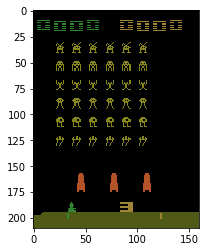

After processing: (65, 160, 1)


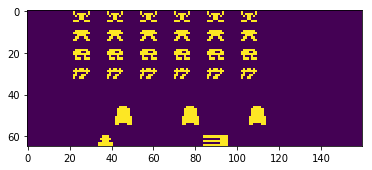

In [2]:
def preprocess(observation):
    observation = observation[65:195,:]
    observation = cv2.cvtColor(cv2.resize(observation, (160, 65)), cv2.COLOR_BGR2GRAY)
    ret, observation = cv2.threshold(observation,1,255,cv2.THRESH_BINARY)
    return np.reshape(observation,(65,160,1))

action0 = 0  # do nothing
observation0, reward0, terminal, info = env.step(action0)
print("Before processing: " + str(np.array(observation0).shape))
plt.imshow(np.array(observation0))
plt.show()
observation0 = preprocess(observation0)
print("After processing: " + str(np.array(observation0).shape))
plt.imshow(np.array(np.squeeze(observation0)))
plt.show()

brain.setInitState(observation0)
brain.currentState = np.squeeze(brain.currentState)


### Network layout

If you were to peak into the BrainDQN_Nature3L.py, in the createQNetwork we define our deep Q neural network. It's made up of :
- 3 convolational layers
- 3 fully connected layers

### Learning

The snipped of code below is set to run forever (while True), so given the fact that the computer we trained this network on was old and only used the CPU, training would happen overnight and during the day. 

As for the output of this cell, we print out every 10,000 time steps : 
- the number or time steps
- the value of epsilon

Epsilon is our exploration vs observation variable which varies inversely to the number of time steps we have performed. Meaning, that at the beginning of our trainig, the agent is young and does not know any better so it will go out and observes the world without a second's thought. However, after 50,000 time steps, it's ready to explore without fear. As time goes on the epsilon decreases and the agent having a better idea about the world (mainly, lasers from aliens hurt so I'm going to blow them up) goes down a path that it knows gives him more rewards.

In [ ]:

while True:
    action = brain.getAction()
    actionmax = np.argmax(np.array(action))
    
    nextObservation,reward,terminal, info = env.step(actionmax)
    
    if terminal:
        nextObservation = env.reset()
    nextObservation = preprocess(nextObservation)
    brain.setPerception(nextObservation,action,reward,terminal)

### Evaluation
This is the fun part (other than learning of course). This is where you see your baby stretch out its legs and kill some aliens. It is important to note that we must set the epsilon value to be low so that the agent tries to impress us with the optimal sequence of actions it's found so far. If we let our epsilon be 0.8, the agent will take somewhat random actions because it thinks that it's still exploring and not just getting down to business.

TIMESTEP 0 / STATE observe / EPSILON 0.2



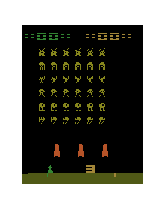
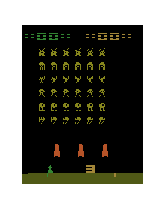
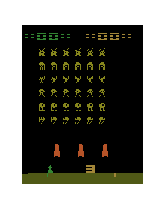
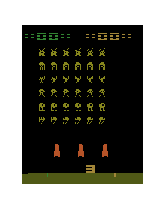
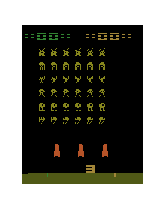
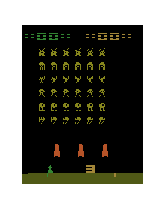
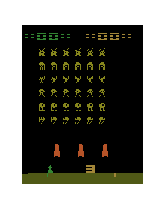
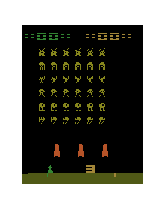
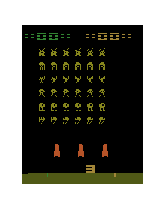
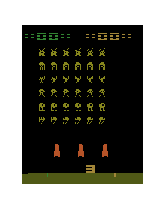
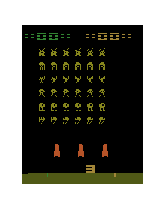
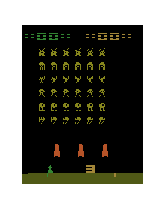
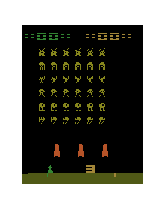
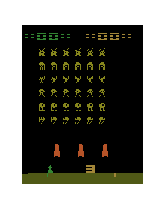
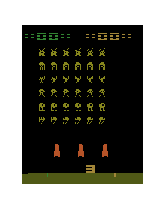
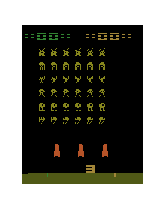
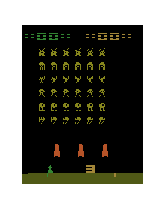
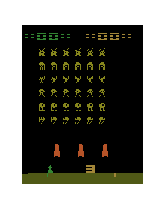
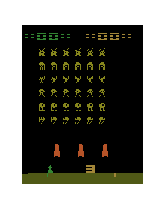
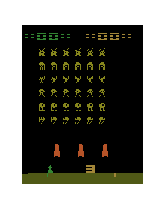
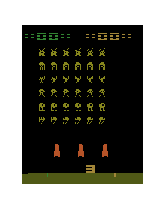
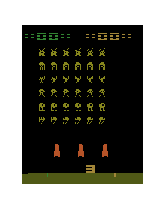
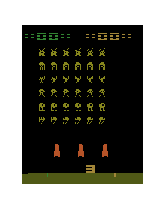
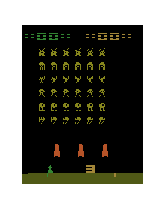
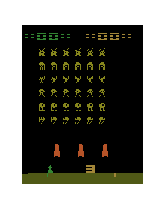
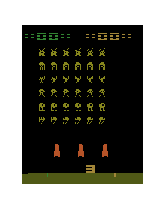
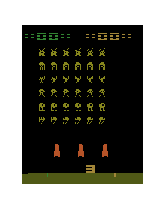
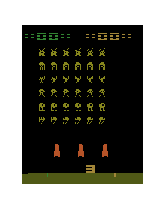
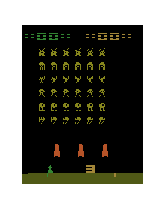
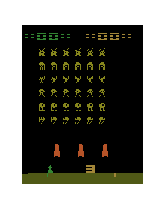
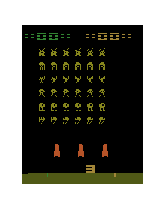
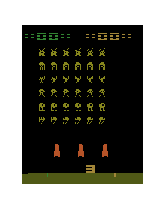
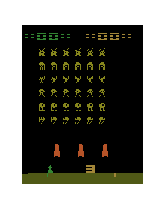
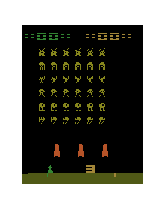
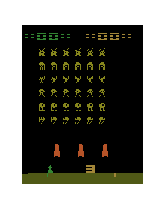
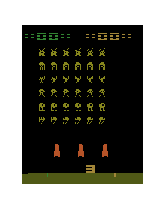
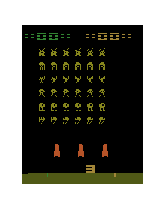
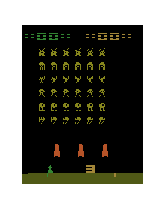
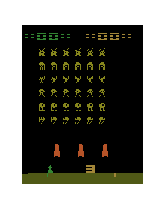
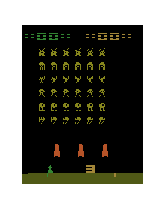
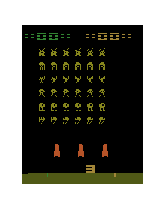
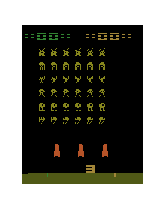
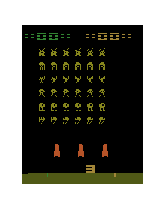
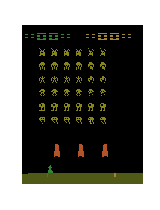
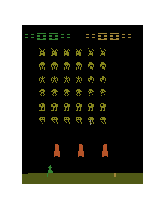
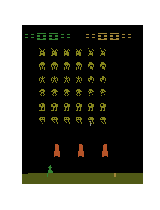
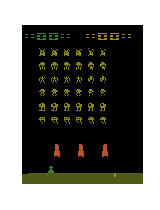
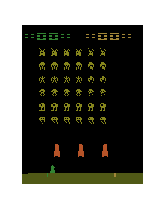
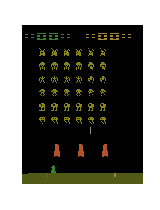
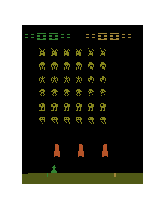
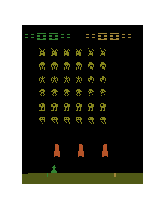
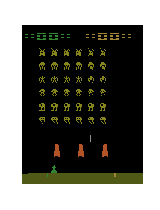
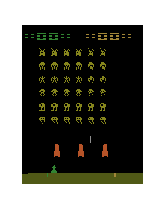
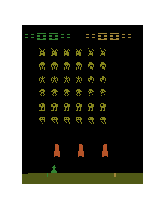
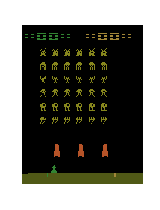
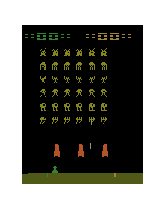
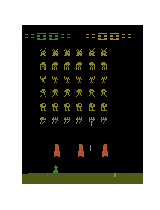
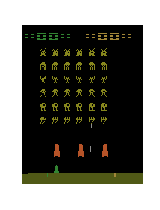
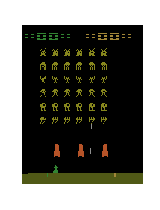
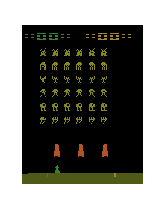
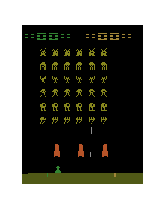
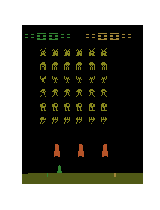
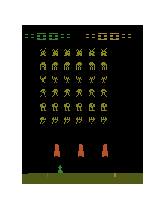
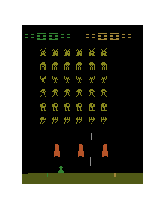
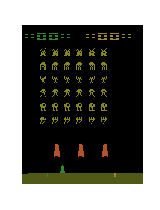
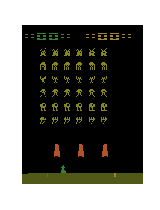
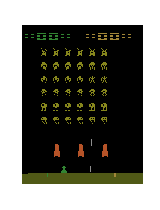
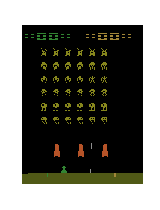
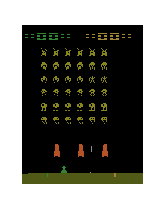
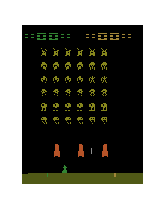
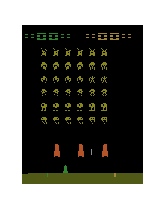
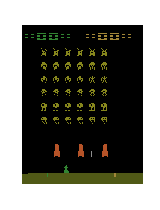
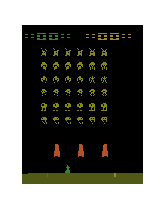
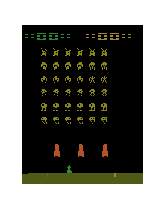
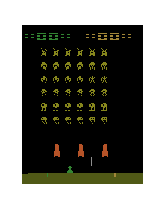
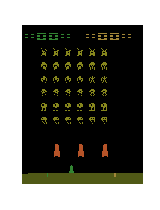
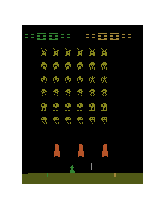
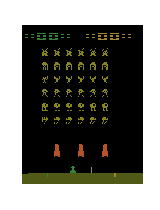
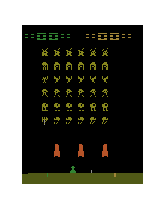
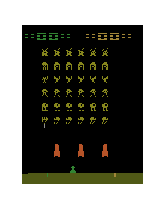
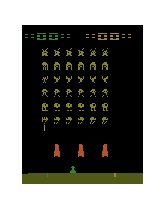
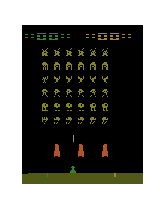
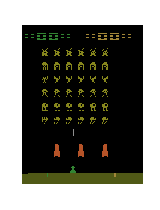
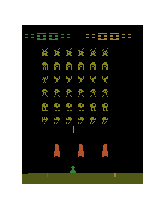
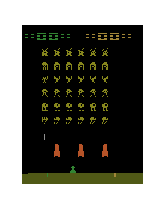
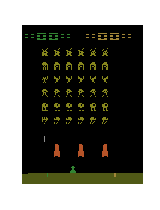
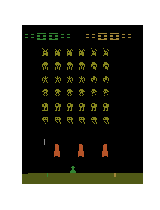
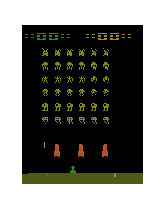
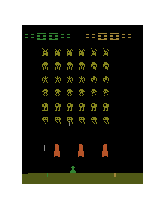
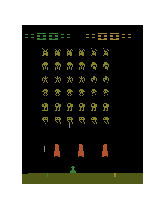
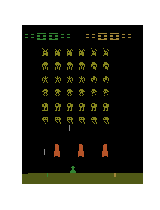
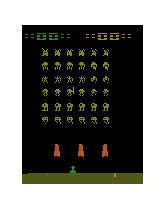
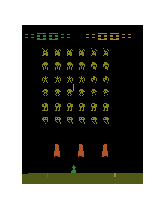
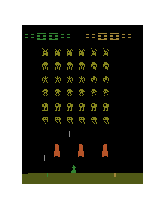
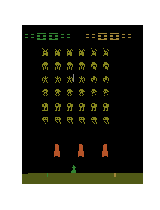
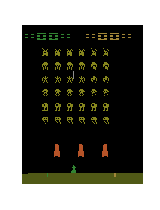
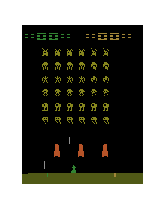
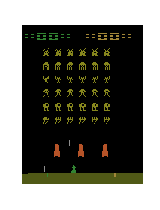
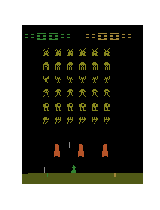
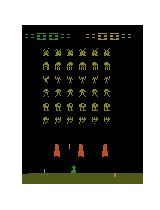
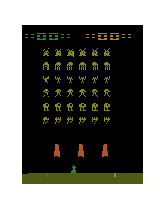
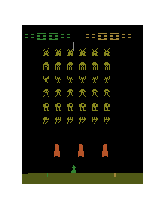
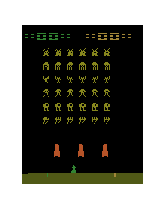
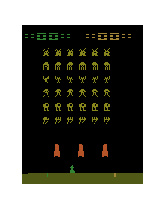
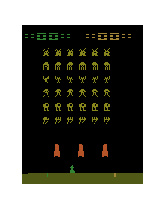
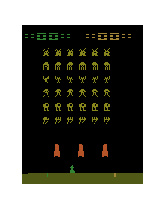
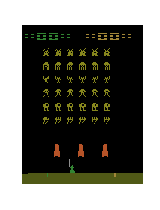
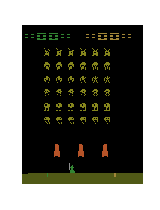
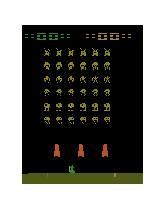
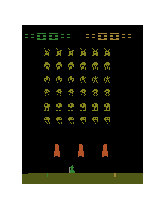
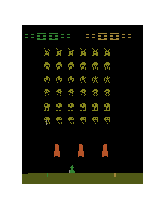
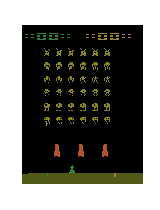
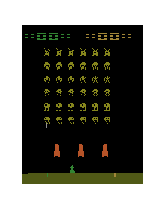
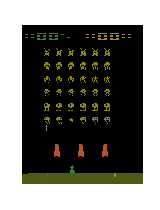
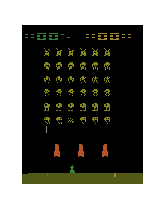
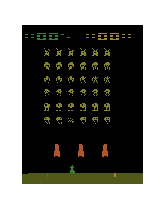
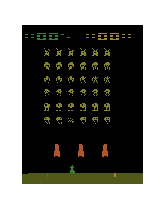
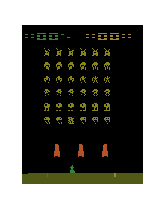
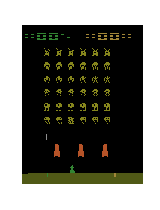
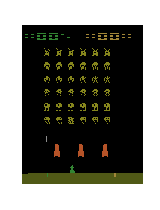
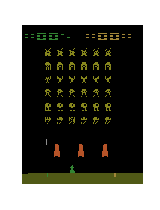
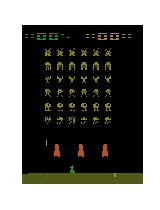
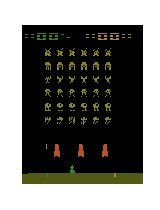
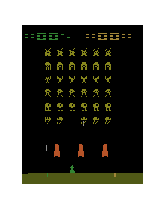
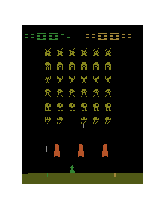
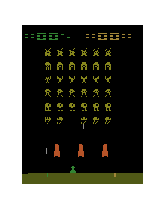
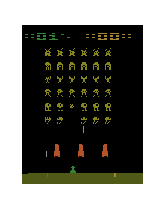
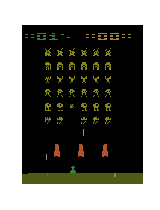
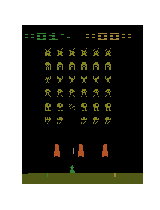
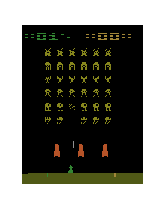
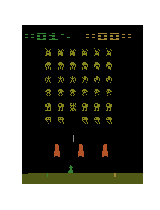
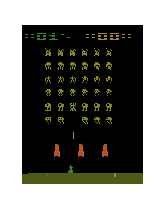
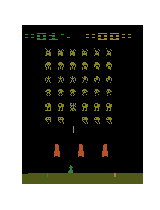
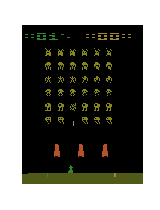
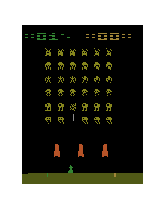
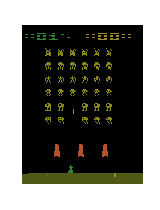
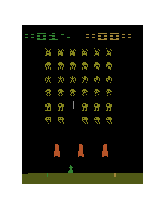
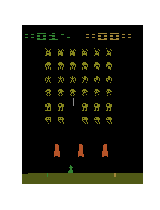
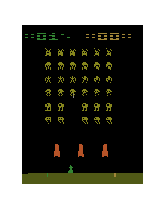
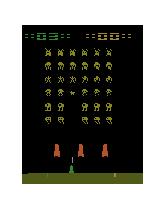
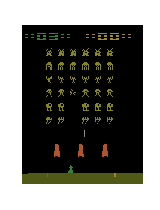
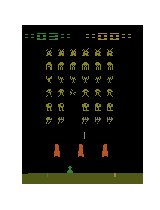
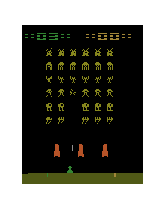
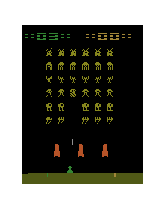
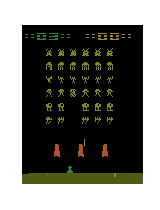
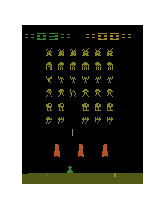
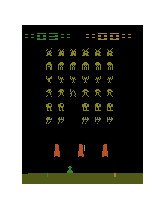
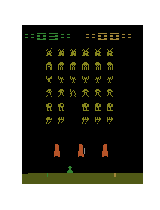
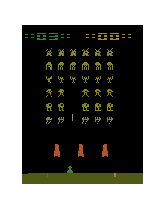
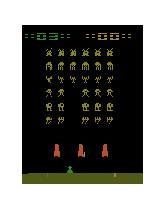
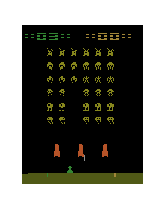
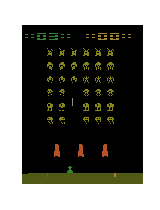
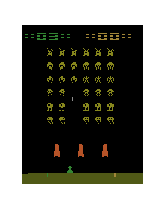
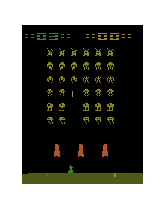
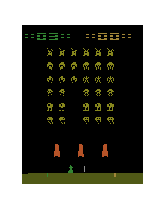
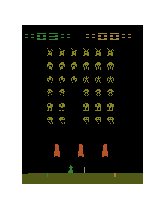
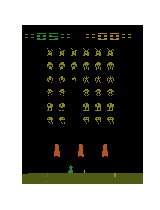
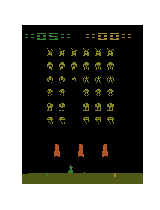
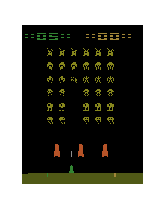
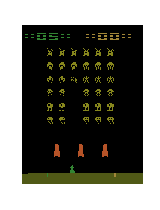
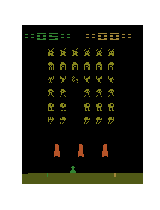
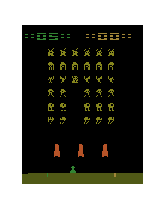
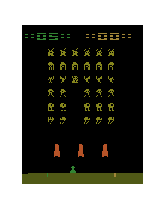
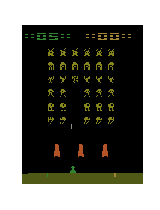
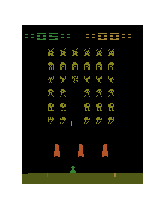
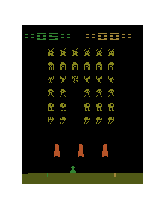
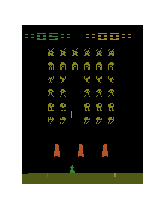
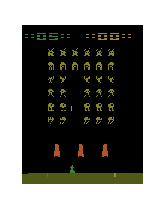
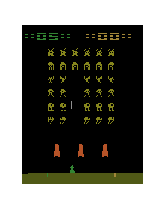
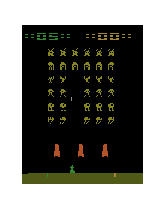
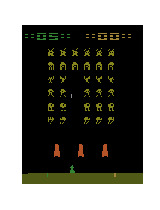
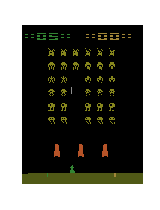
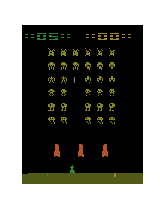
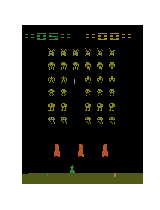
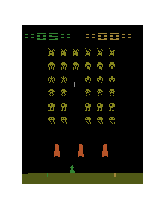
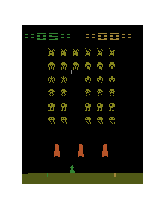
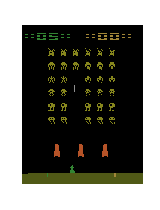
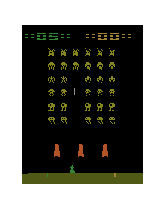
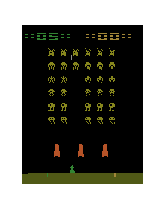
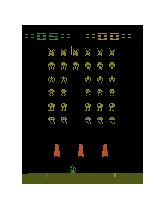
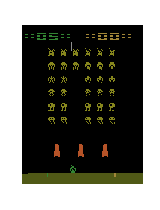
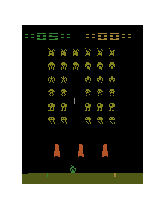
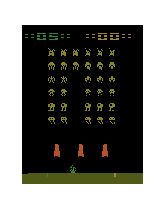
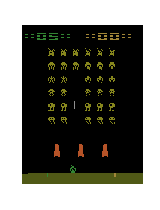
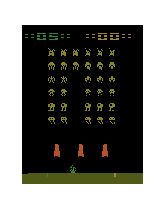
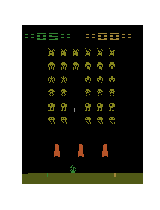
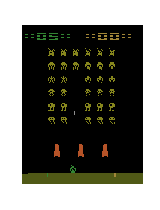
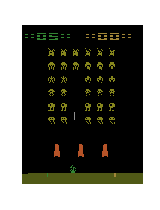
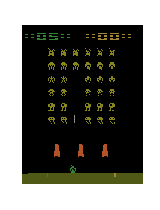
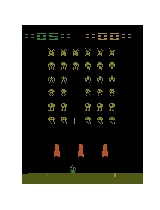
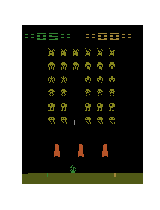
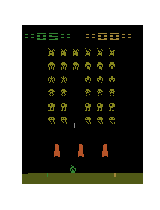
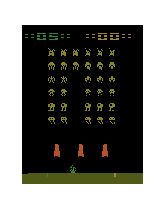
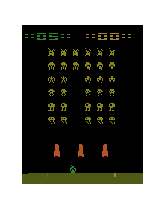
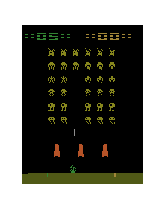
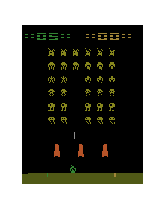
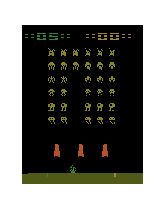
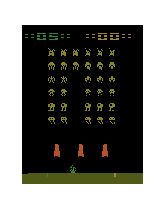
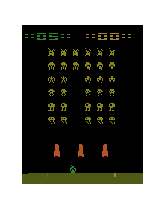
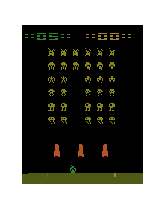
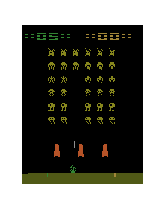
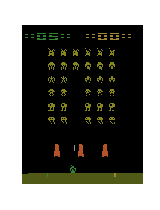
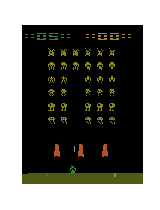
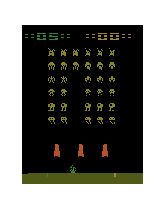
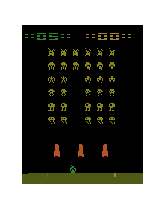
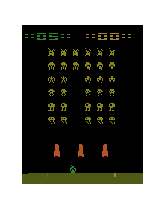
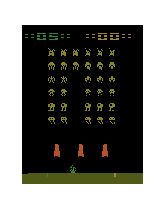
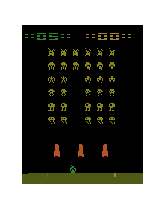
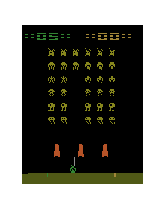
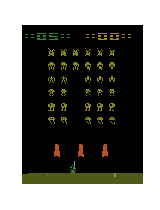
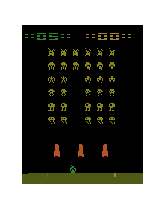
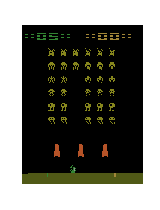
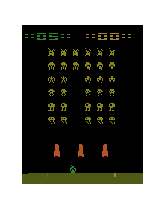
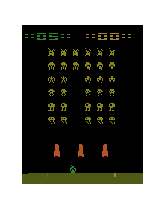
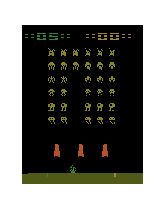
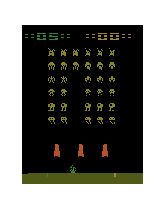
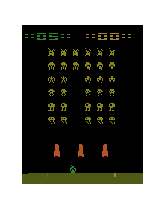
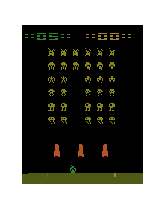
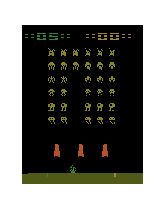
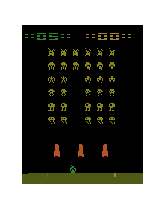
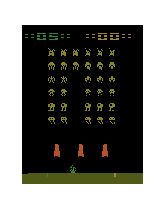
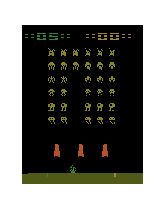
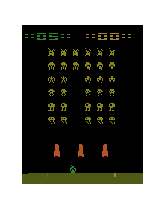
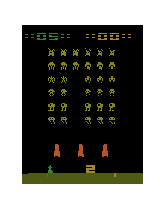
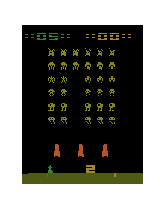
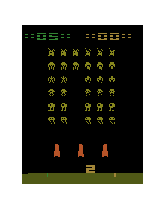
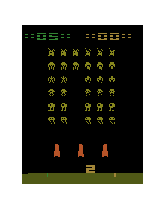
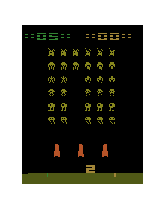
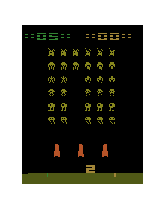
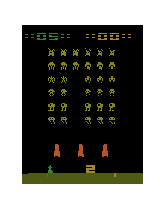
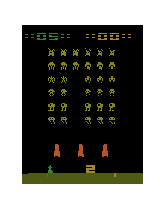
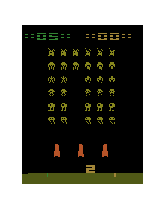
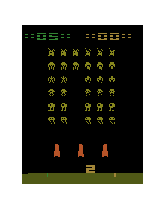
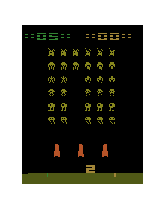
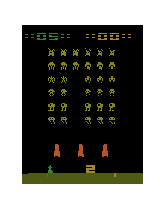
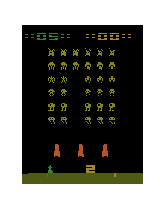
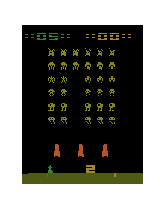
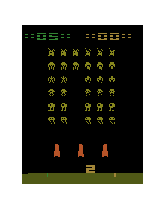
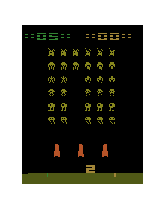
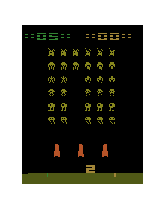
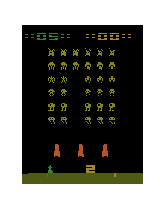
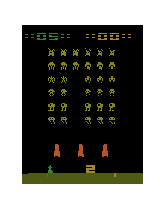
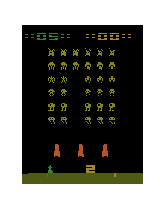
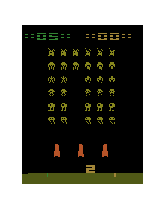
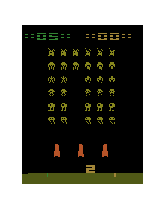
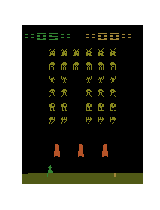
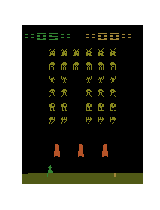
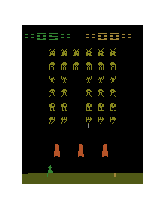
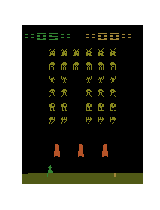
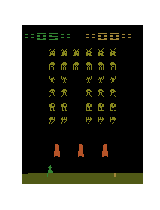
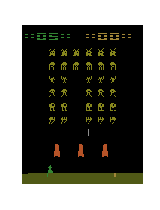
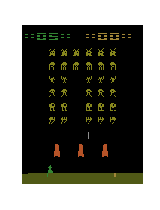
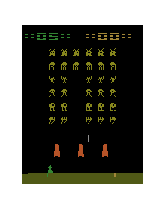
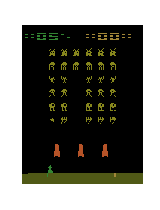
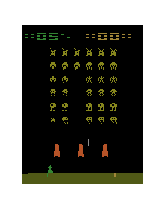
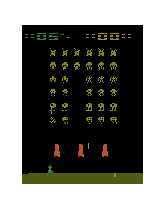
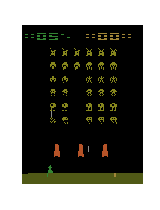
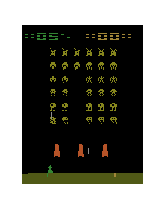
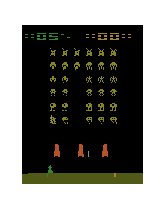
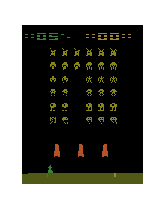
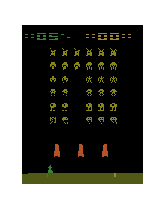
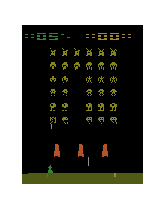
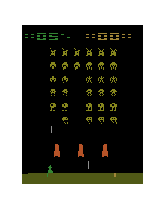
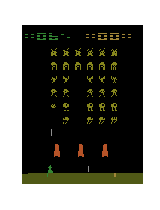
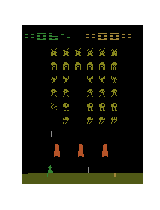
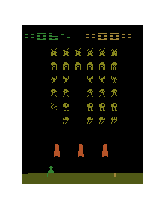
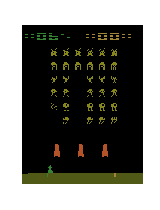
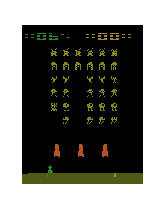
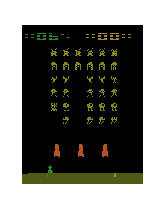
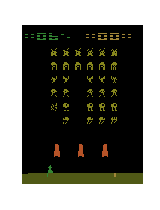
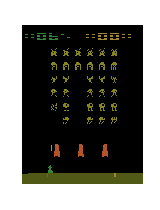
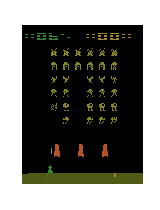
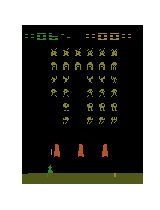
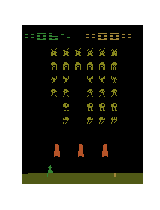
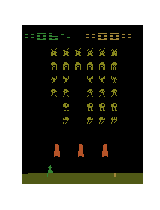
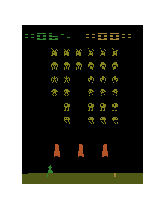
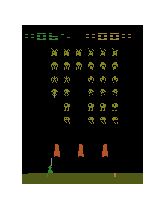
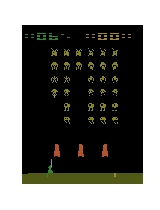
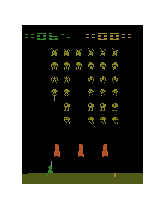
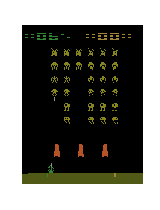
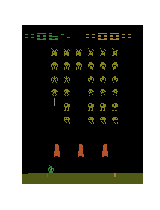
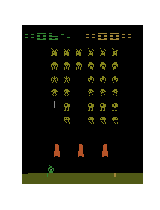
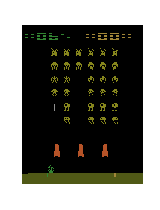
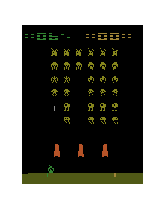
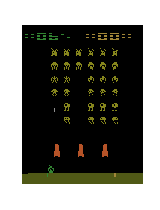
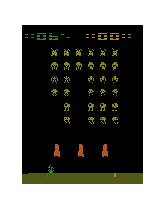
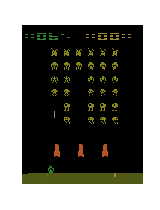
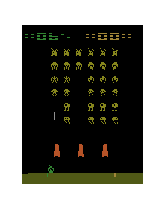
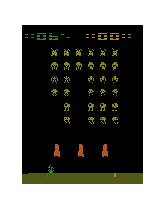
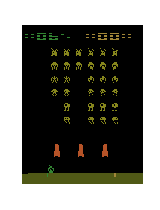
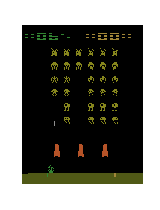
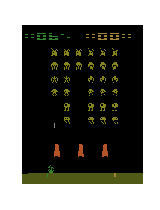
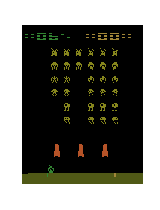
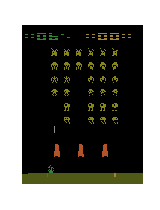
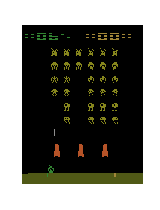
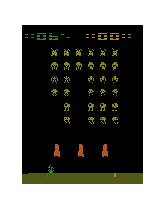
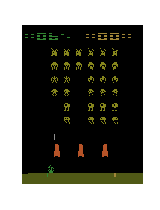
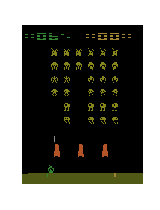
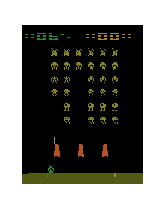
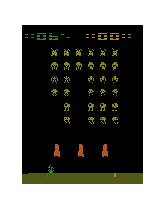
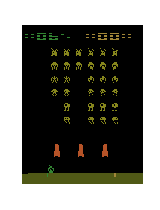
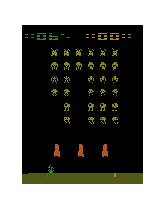
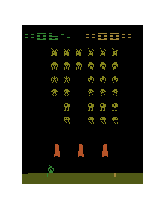
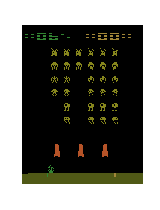
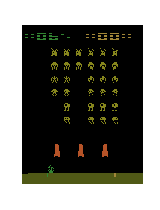
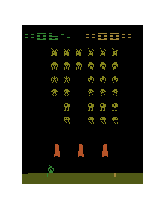
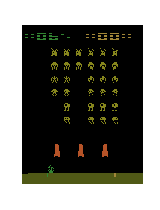
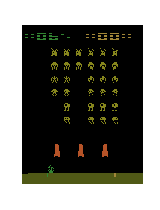
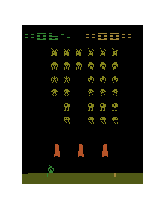
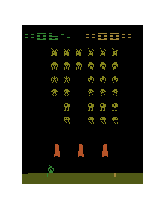
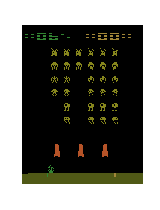
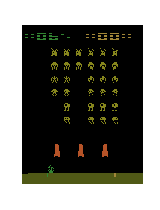
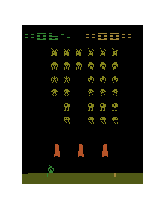
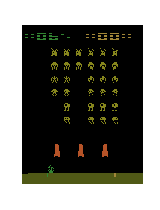
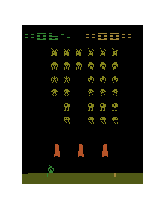
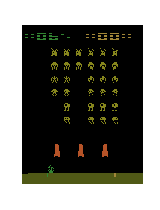
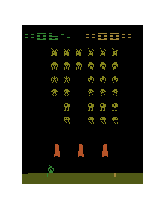
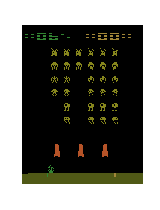
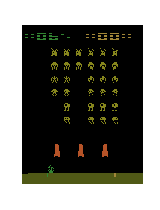
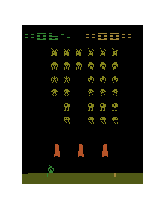
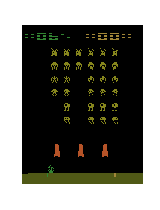
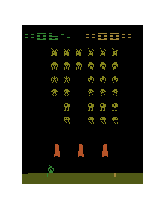
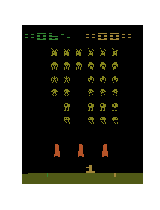
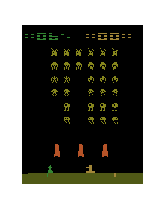
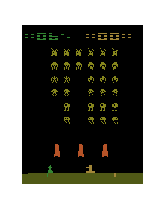
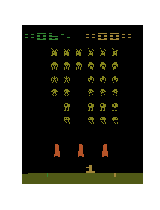
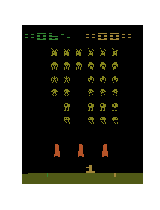
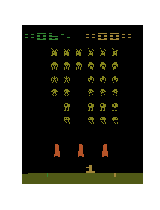
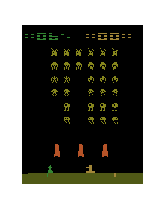
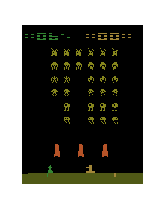
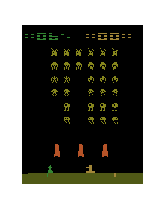
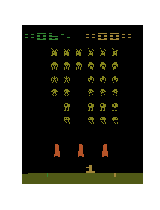
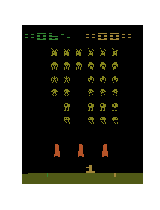
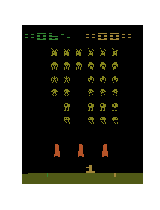
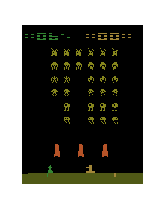
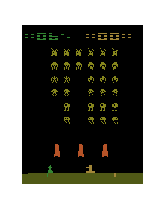
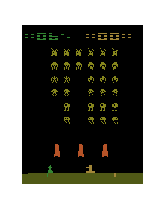
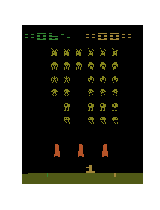
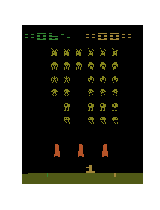
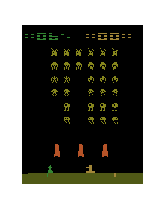
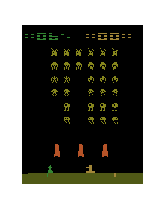
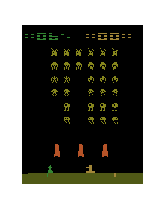
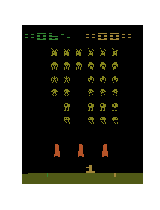
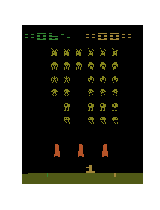
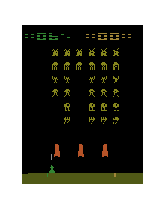
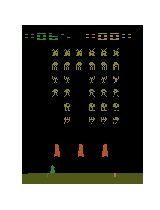
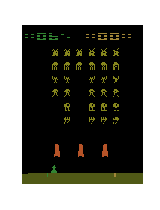
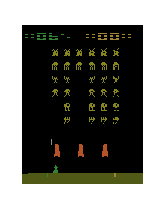
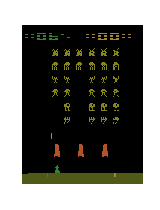
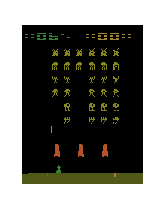
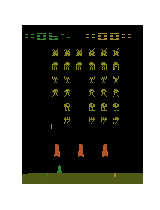
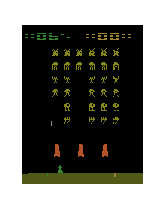
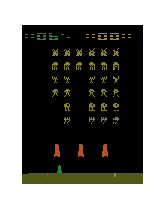
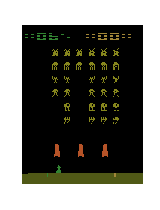
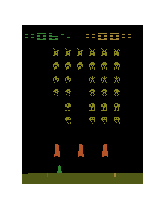
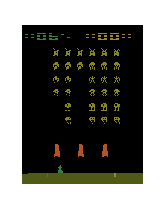
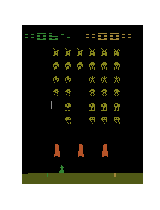
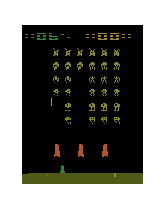
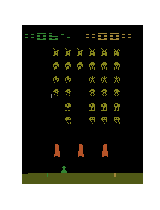
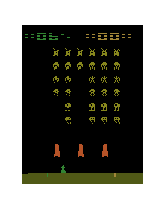
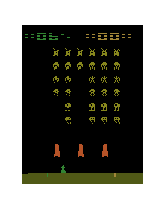
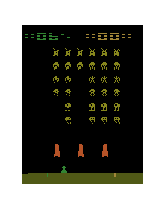
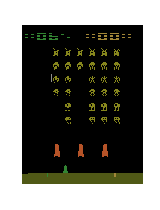
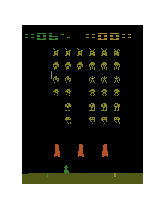
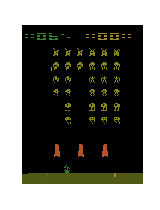
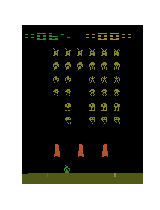
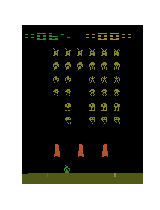
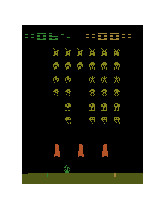
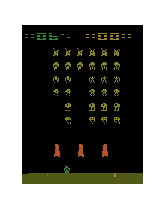
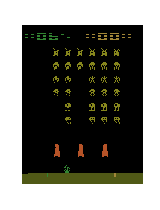
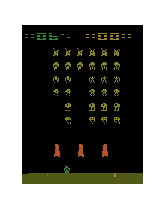
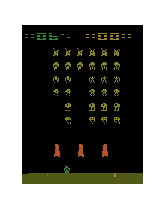
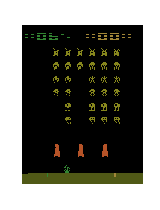
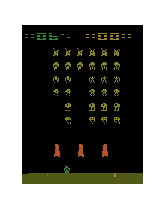
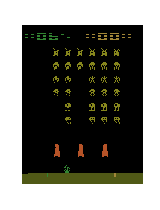
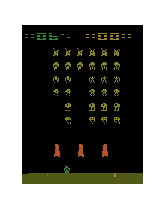
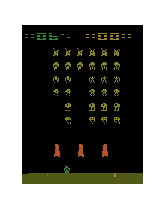
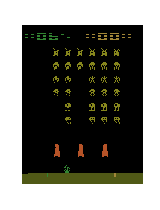
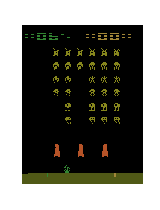
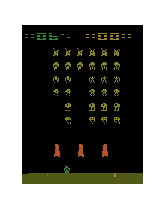
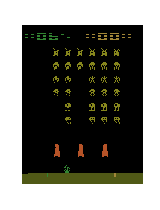
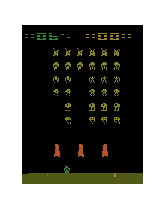
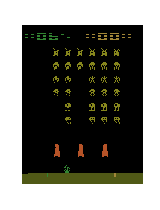
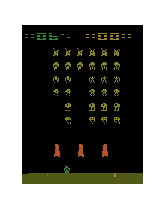
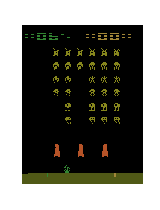
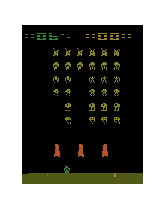
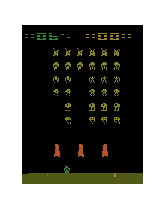
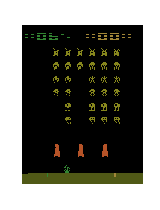
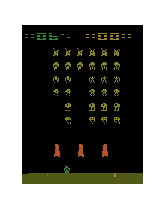
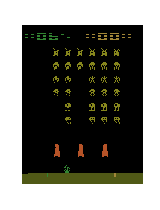
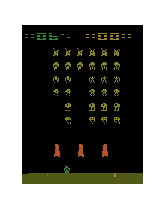
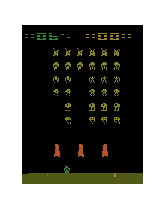
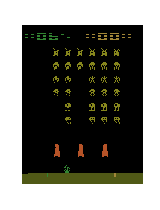
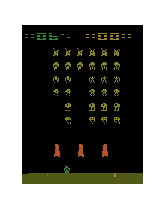
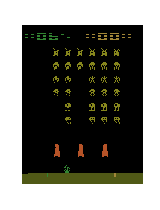
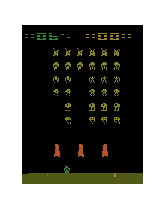
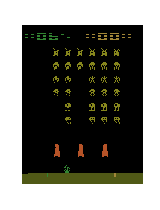
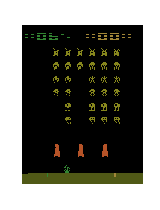
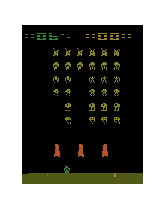
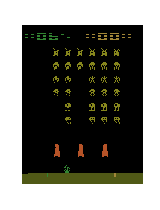
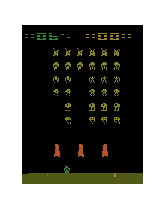
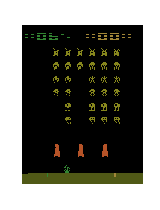
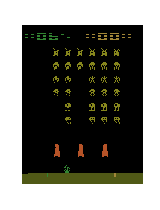
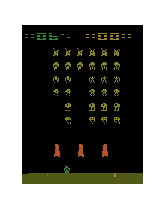
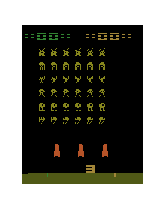
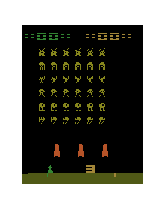
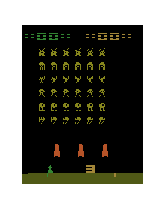
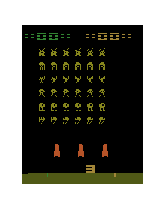
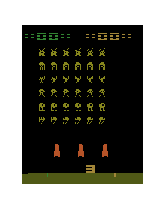
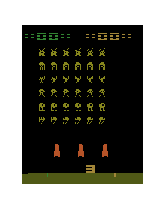
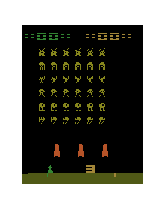
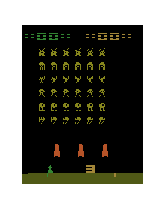
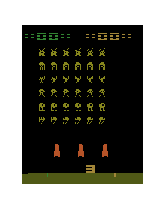
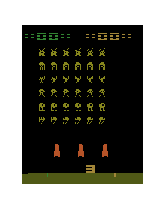
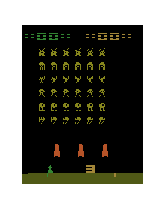
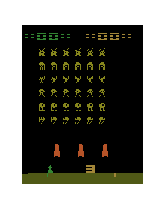
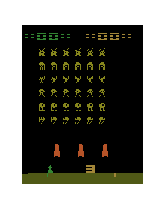
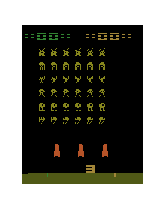
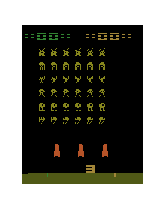
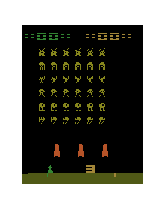
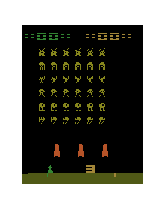
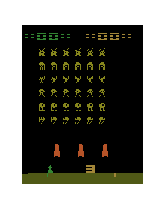
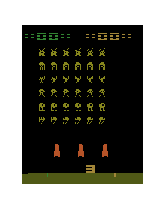
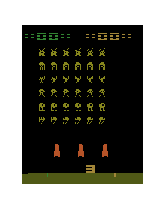
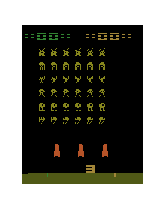
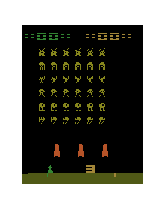
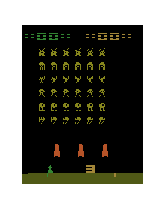
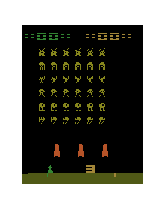
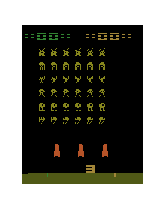
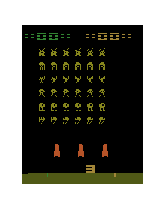
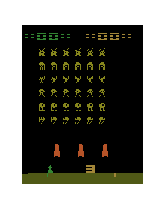
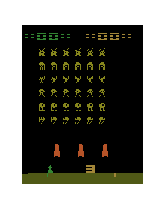
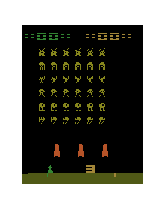
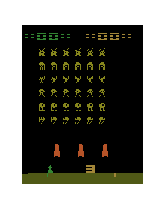
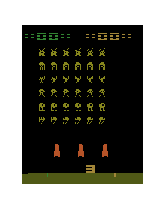
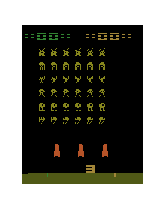
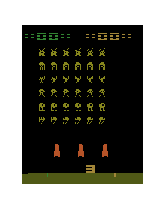
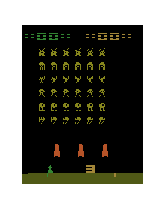
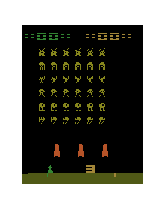
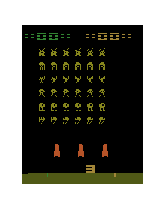
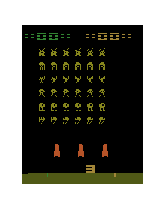
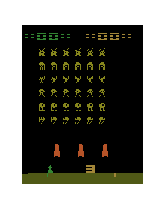
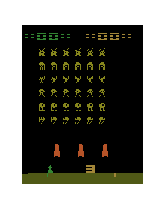
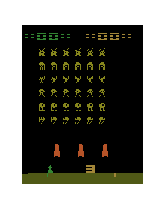
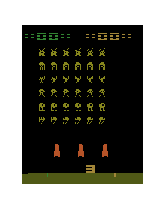
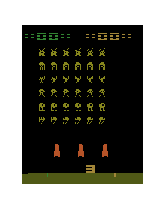
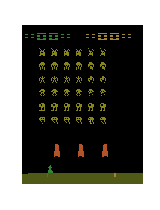
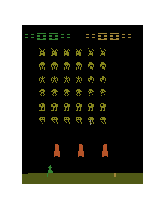
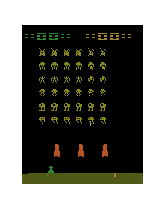
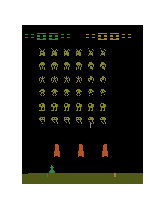
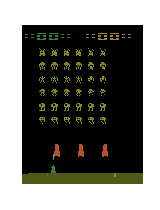
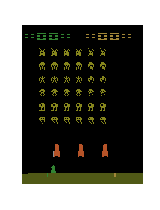
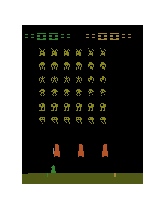
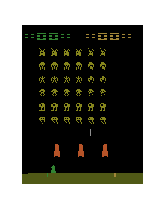
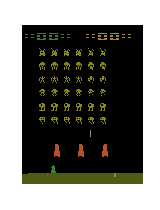
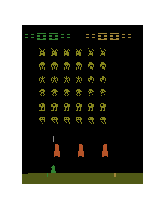
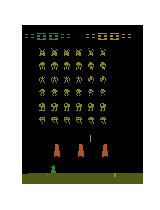
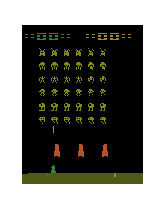
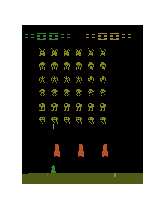
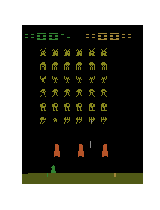
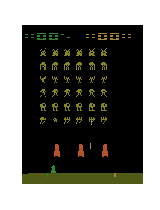
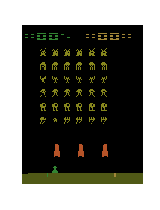
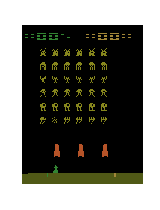
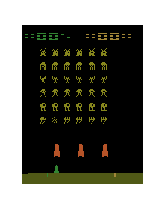
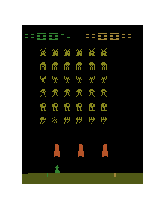
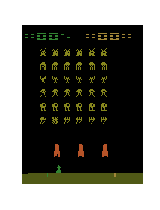
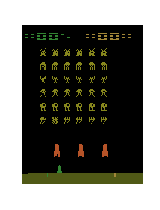
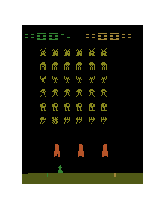
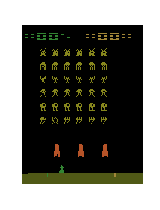
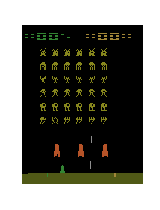
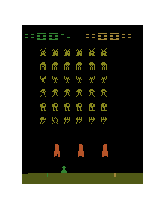
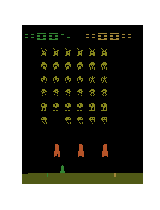
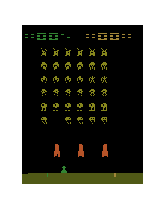
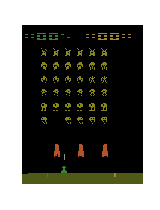
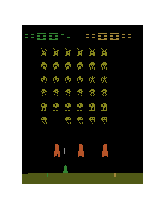
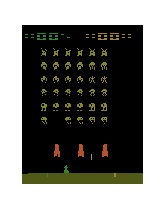
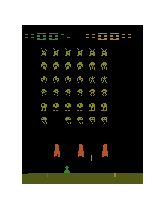
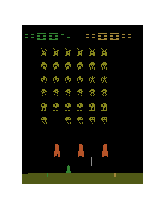
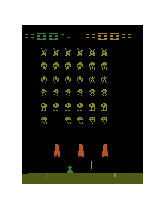
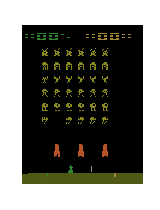
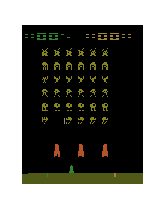
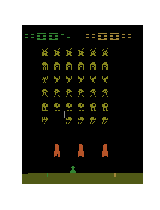
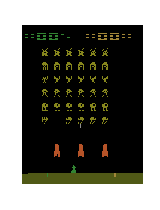
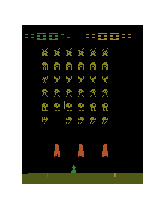
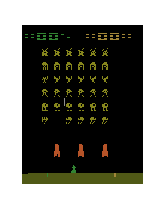
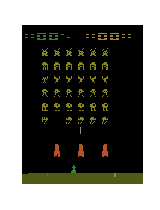
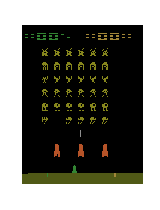
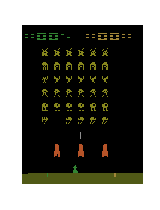
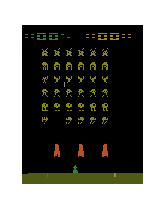
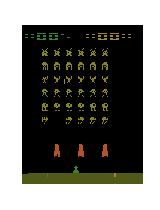
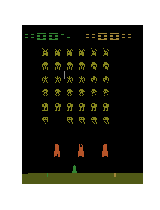
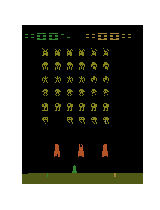
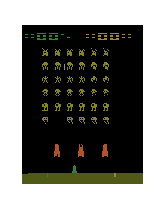
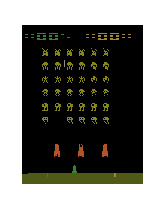
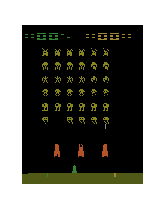
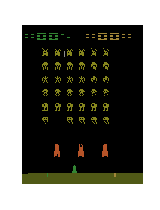
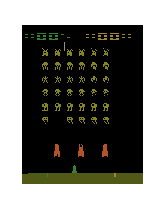
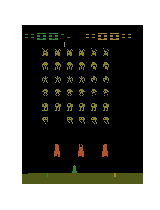
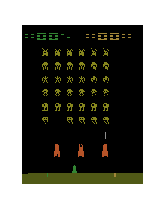
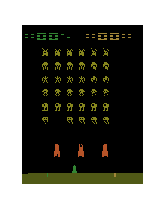
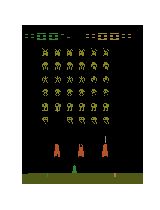
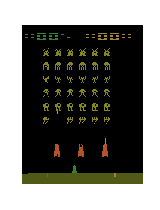
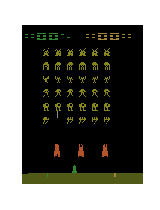
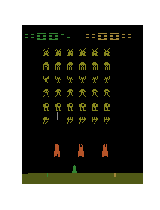
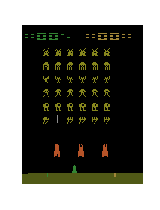
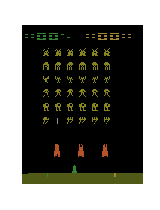
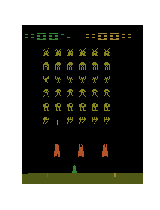
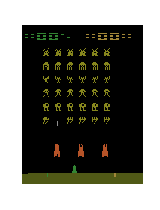
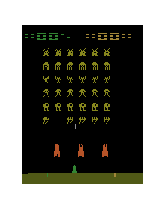
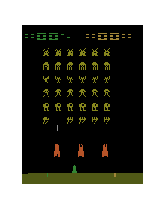
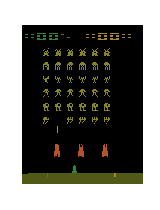
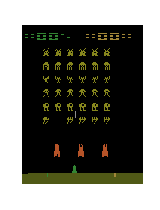
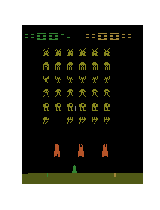
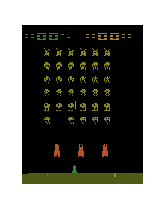
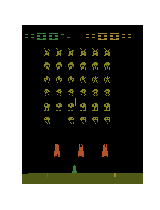
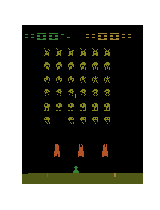
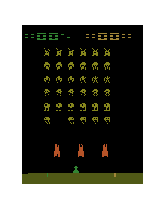
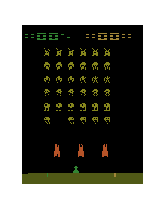
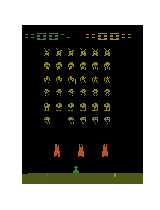
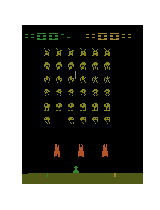
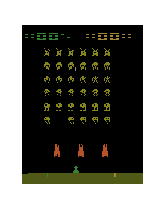
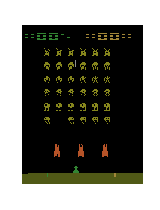
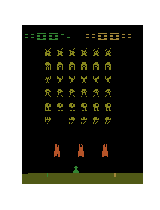
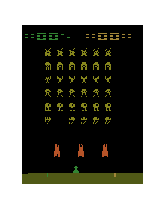
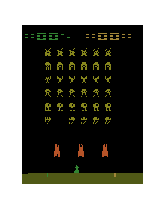
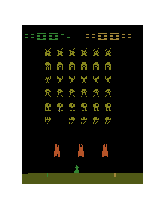
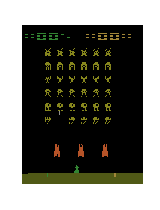
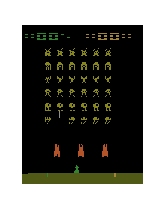
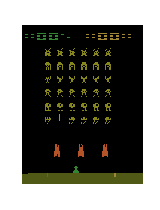
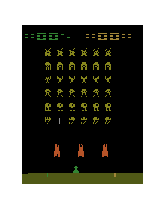
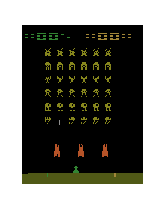
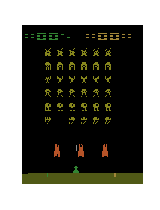
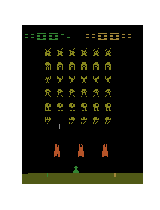
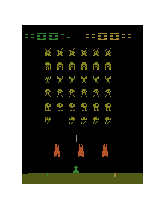
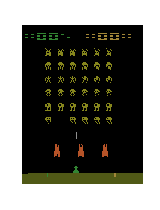
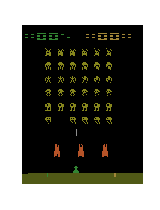
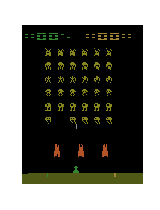
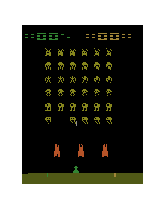
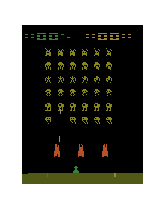
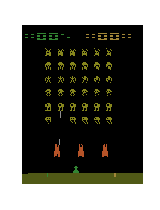
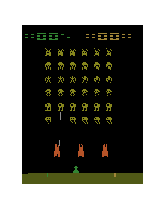
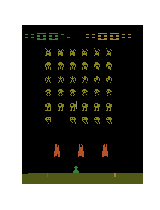
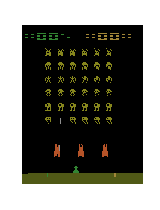
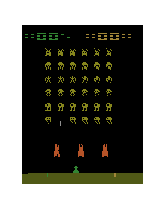
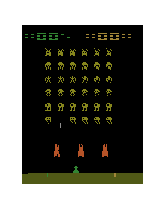
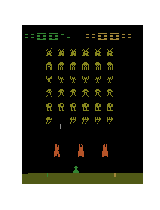
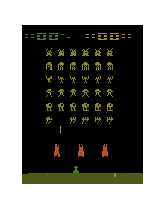
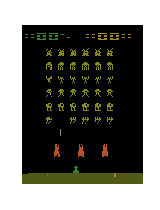
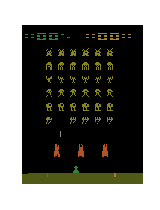
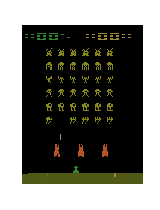
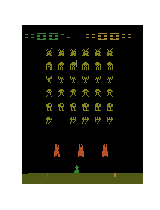
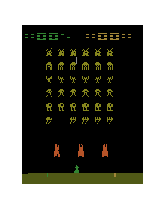
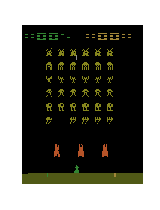
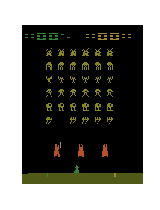
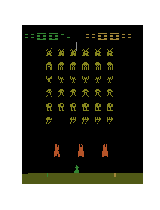
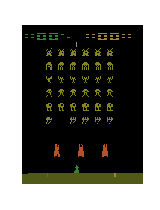
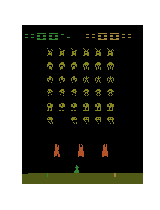
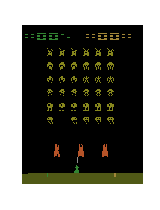
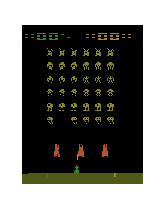
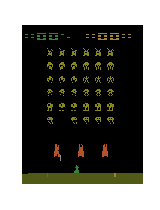
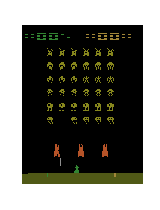
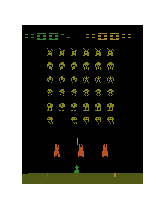
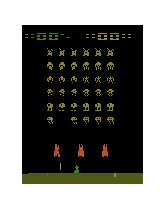
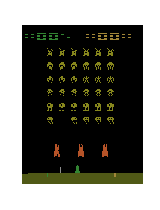
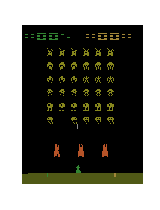
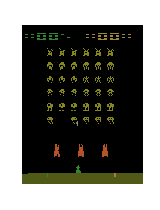
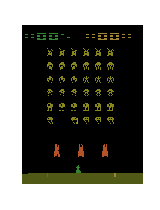
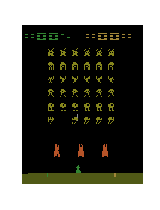
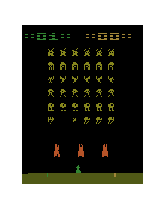
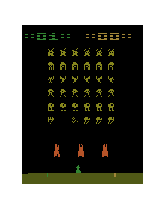
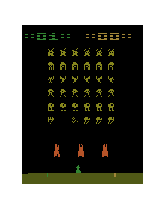
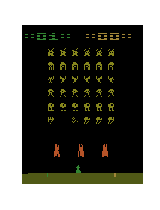
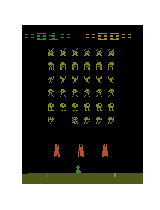
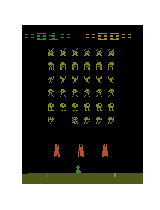
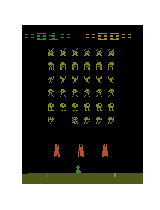
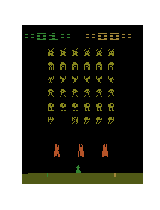
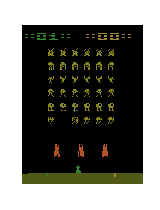
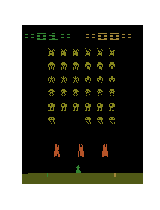
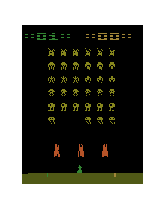
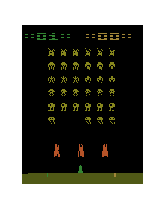
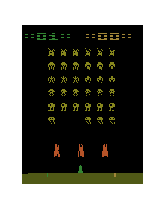
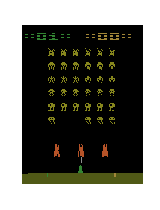
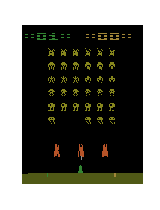
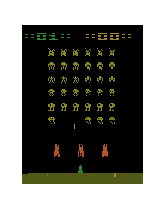
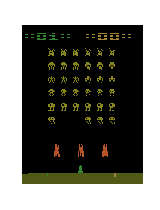
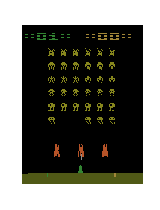
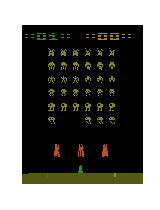
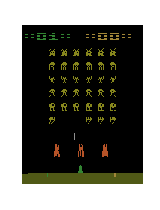
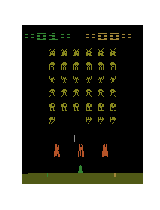
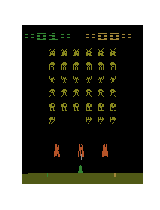
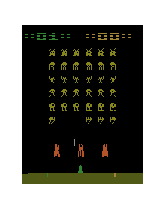
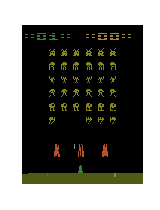
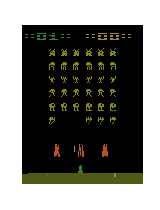
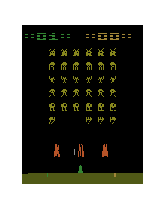
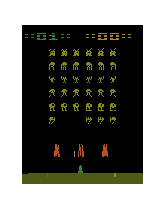
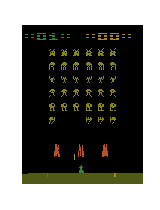
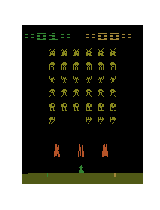
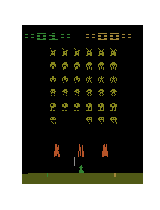
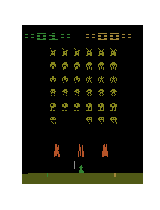
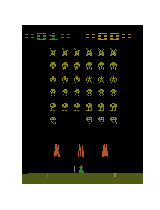
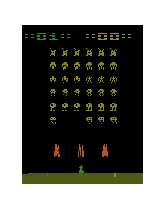
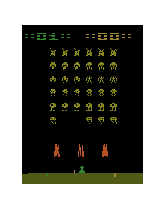
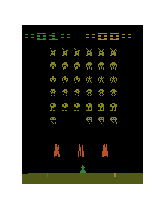
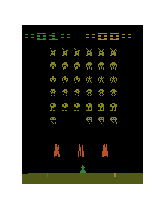
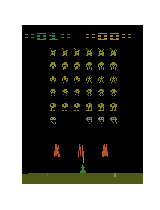
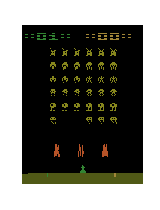
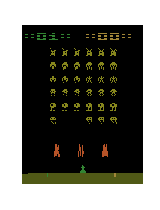
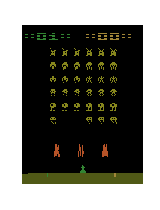
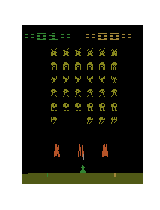
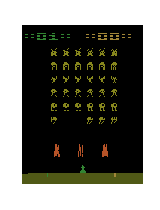
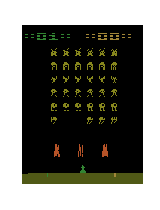
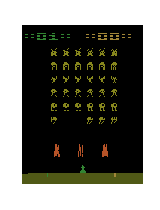
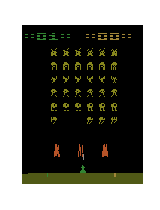
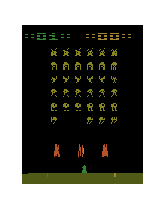
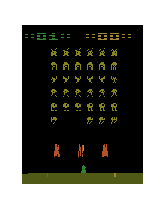
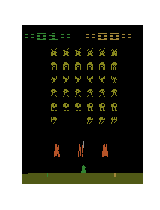
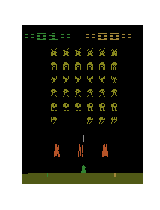
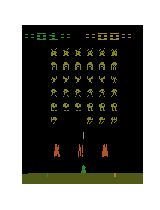
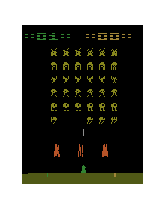
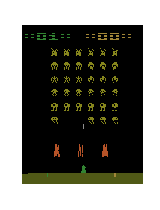
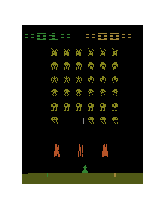
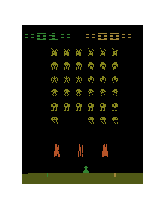
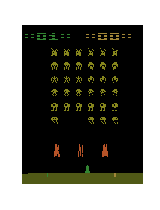
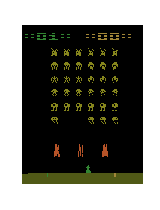
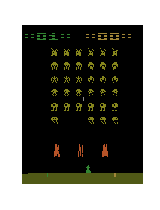
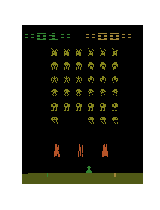
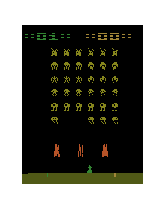
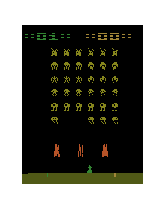
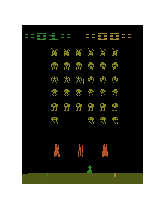
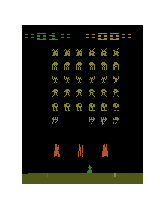
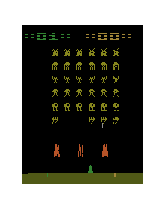
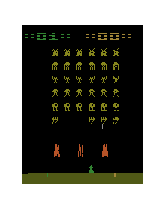
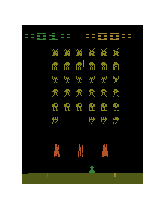
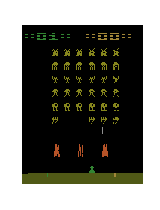
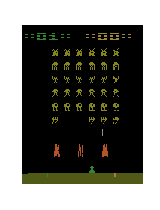
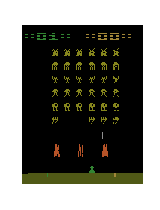
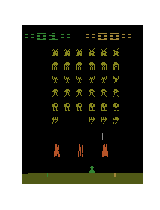
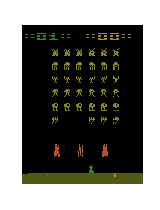
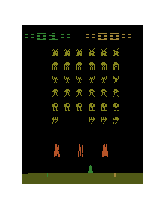
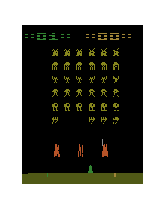
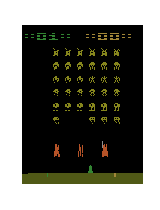
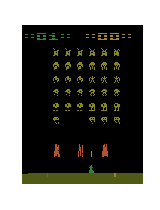
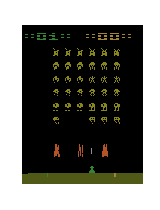
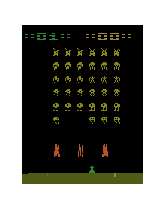
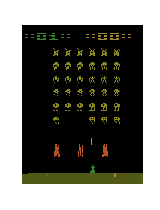
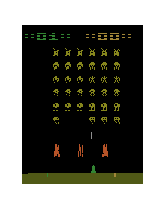
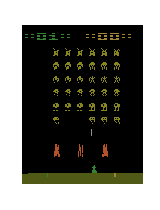
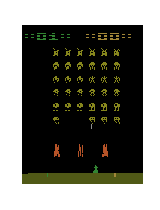
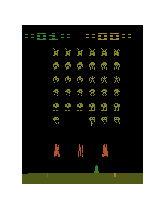
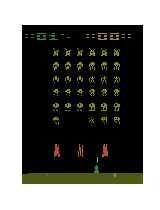
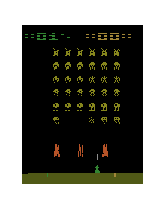
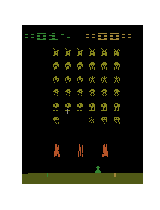
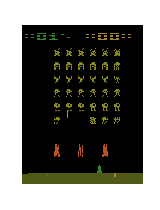
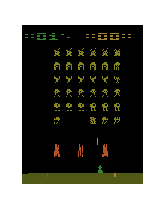
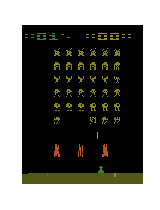
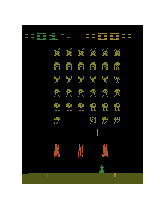
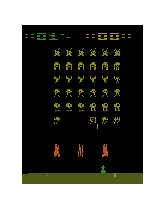
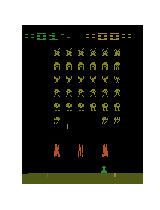
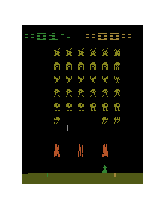
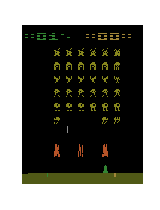
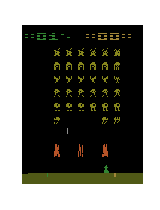
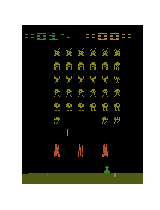
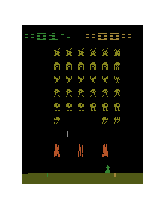
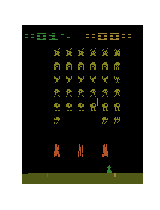
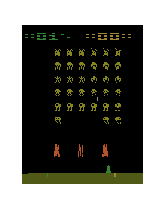
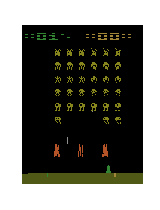
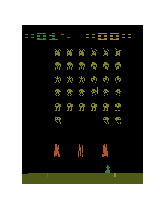
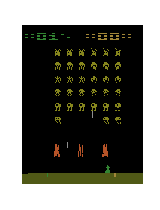
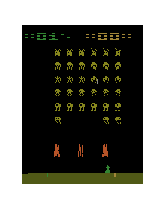
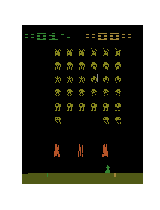
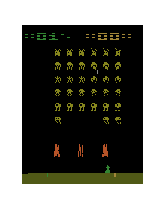
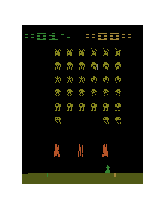
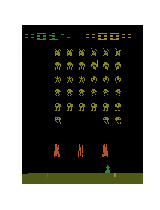
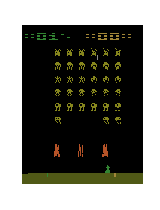
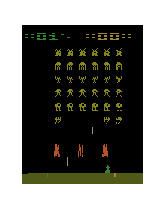
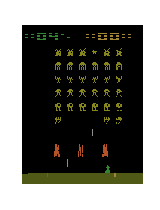
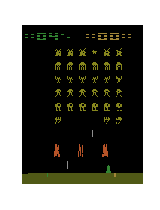
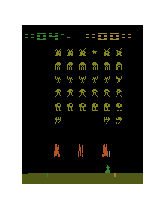
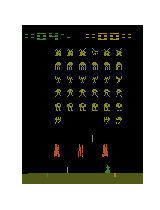
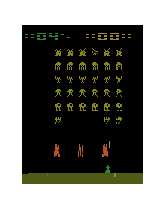
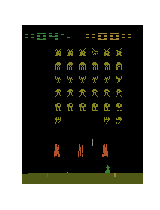
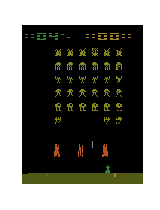
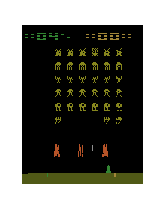
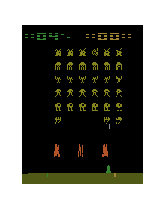
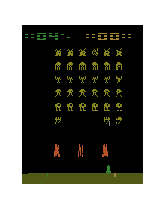
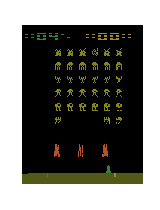
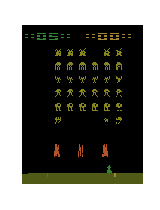
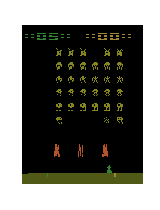
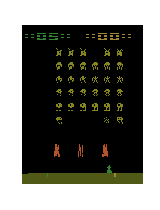
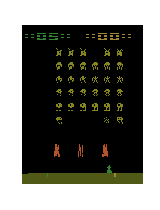
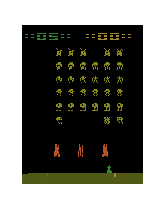
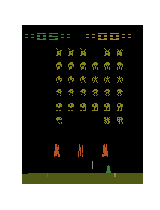
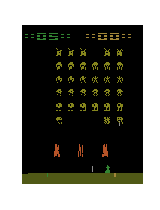
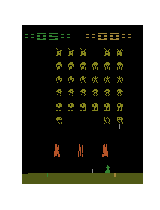
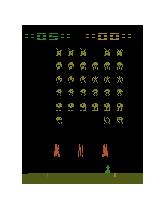
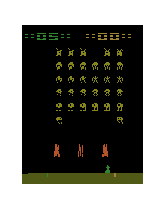
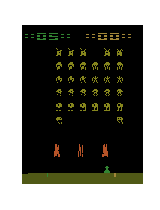
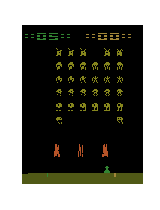
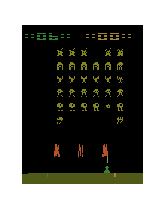
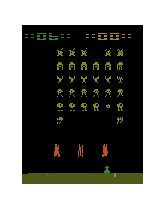
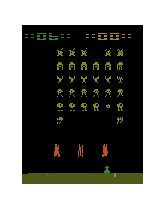
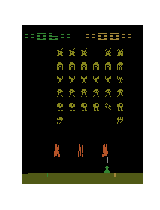
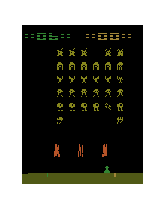
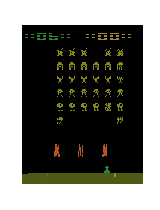
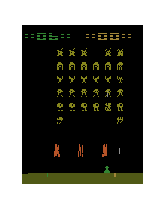
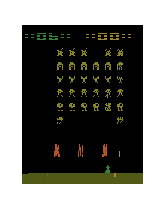
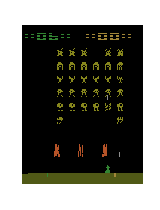
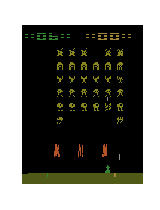
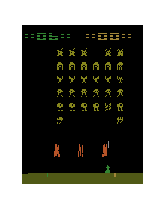
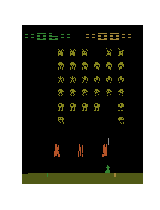
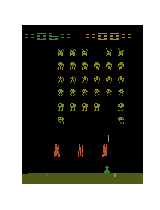
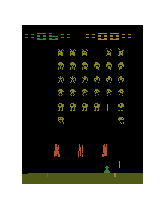
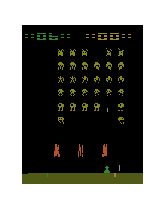
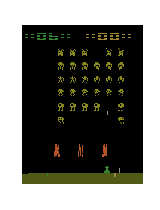
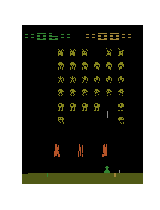
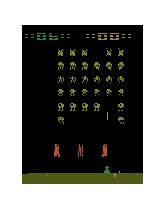
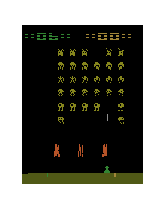
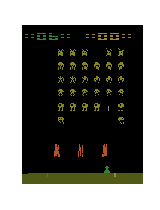
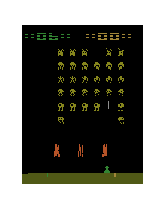
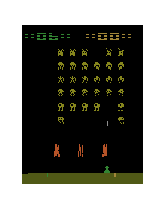
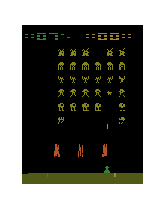
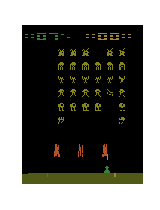
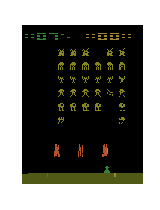
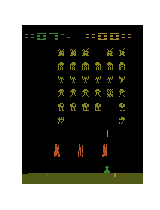
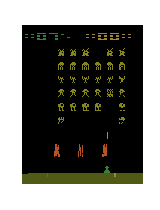
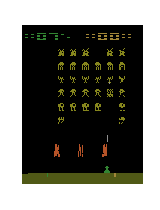
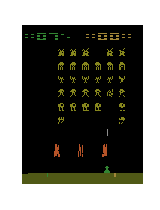
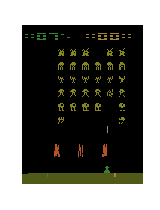
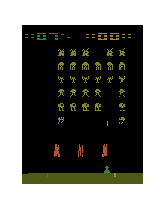
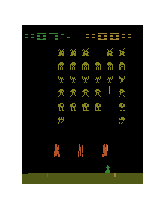
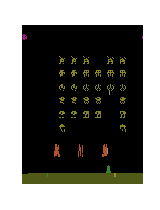
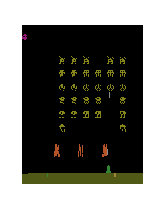
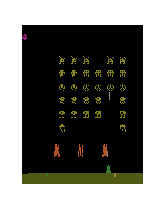
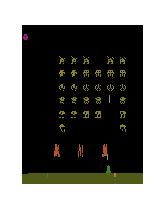
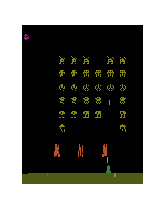
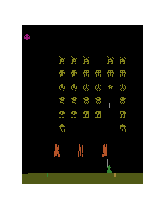
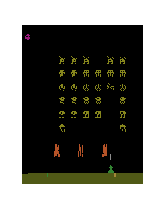
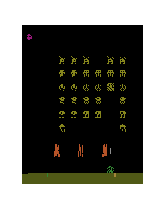
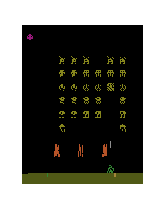
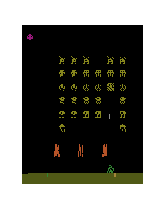
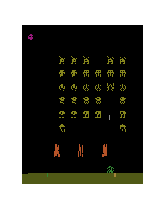
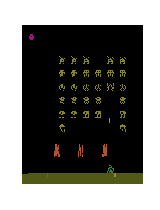
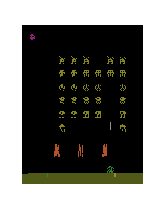
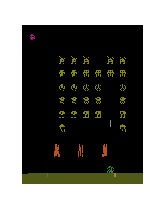
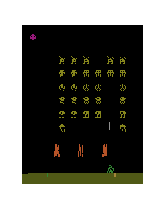
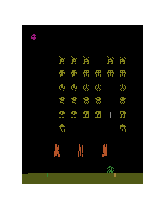
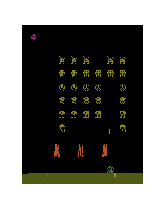
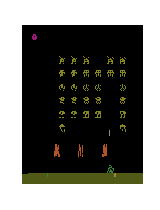
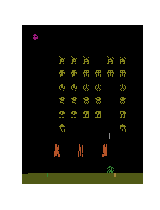
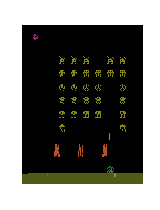
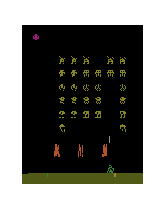
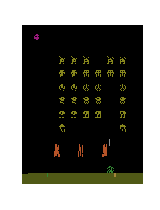
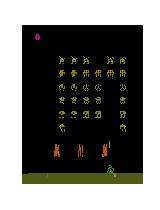
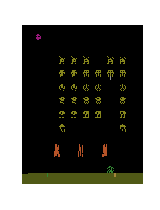
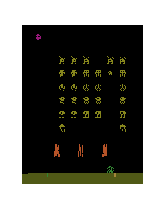
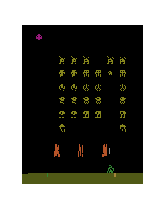
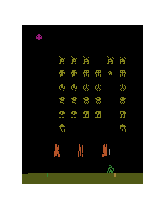
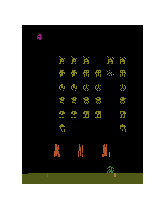
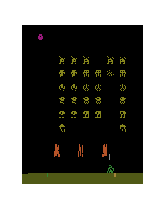
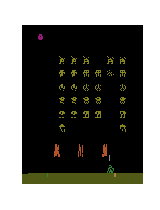
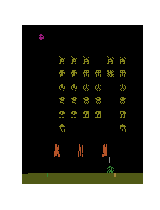
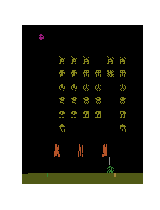
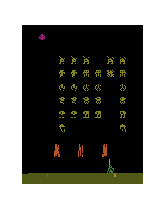
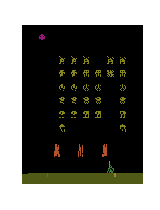
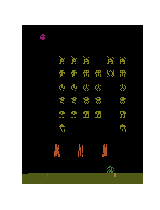
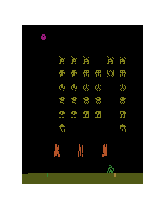
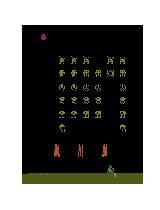
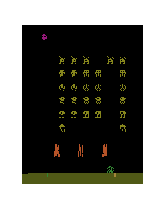
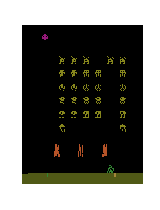
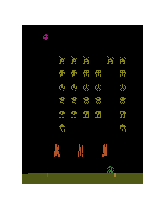
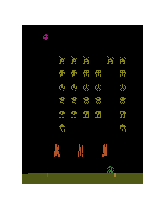
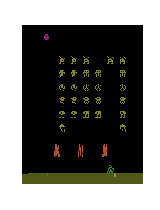
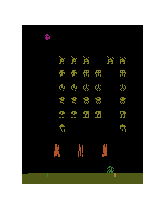
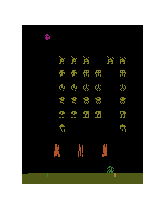
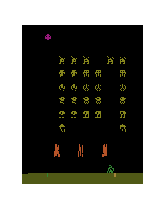
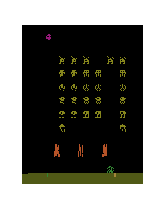
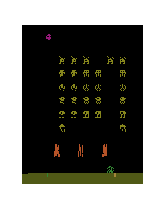
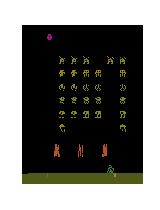
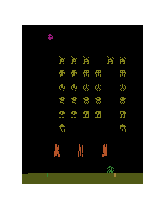
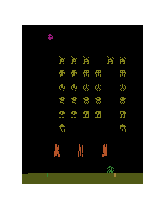
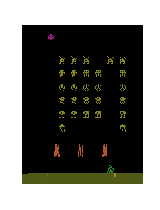
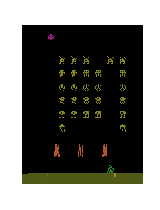
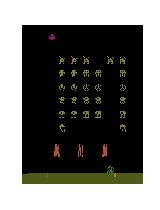
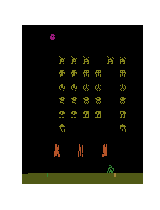
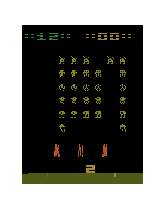
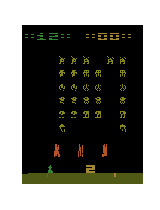
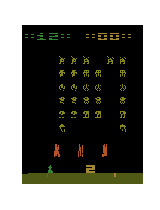
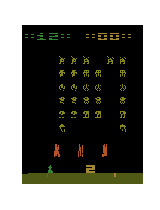
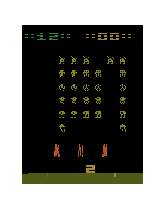
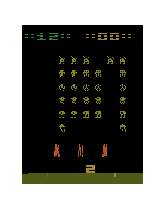
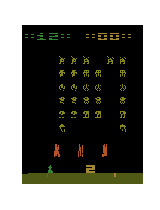
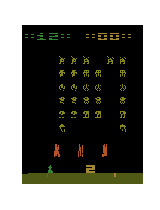
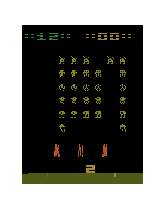
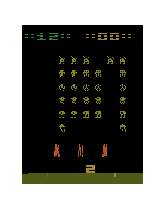
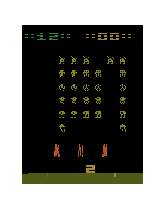
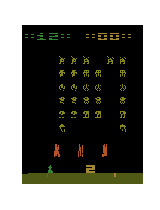
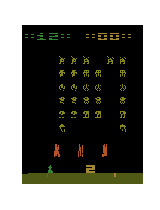
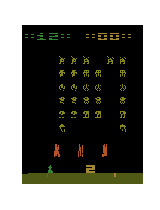
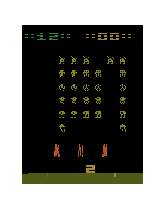
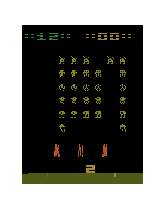
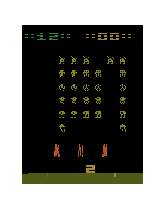
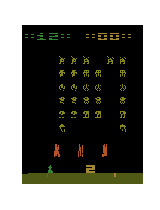
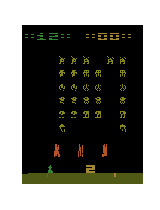
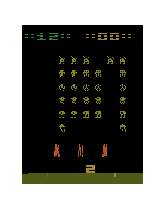
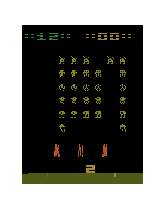
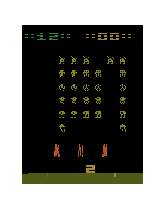
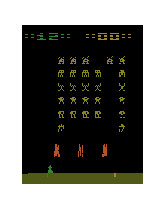
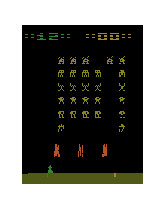
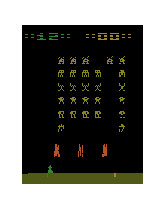
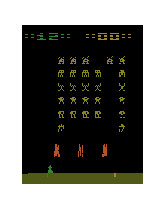
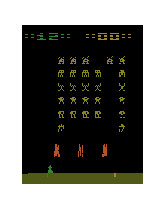
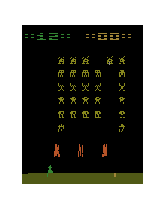
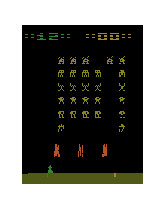
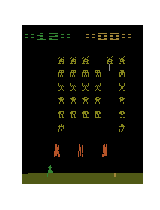
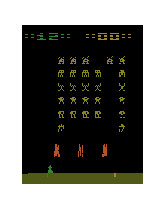
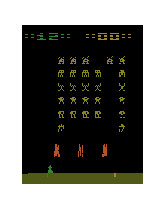
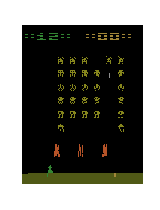
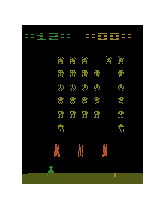
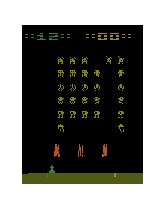
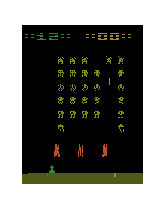
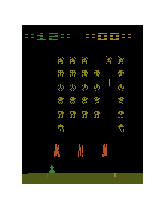
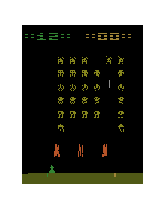
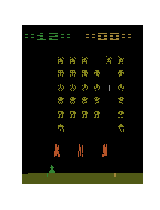
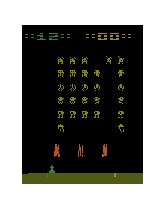
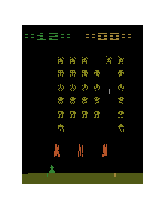
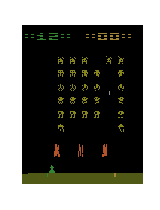
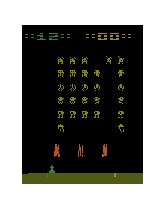
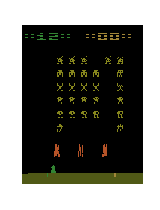
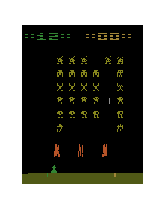
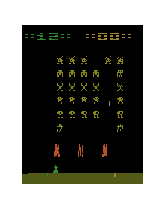
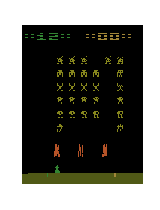
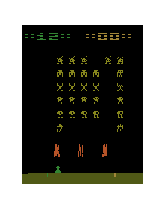
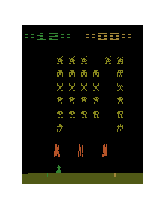
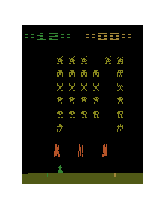
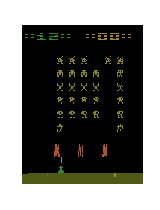
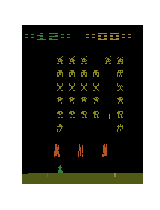
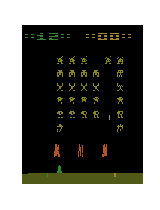
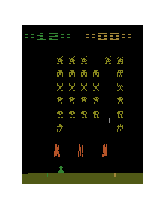
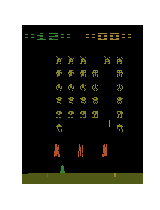
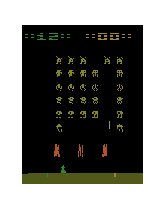
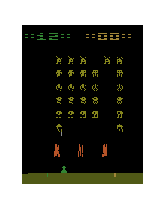
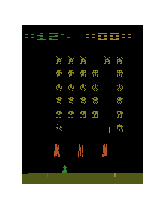
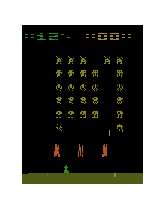
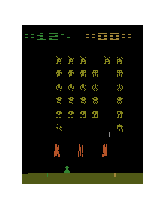
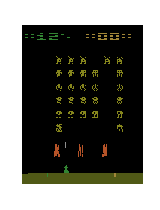
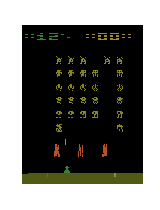
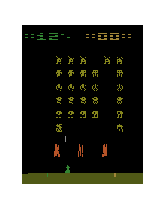
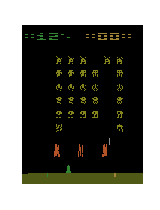
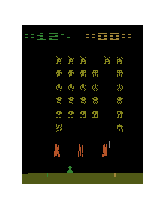
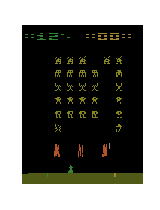
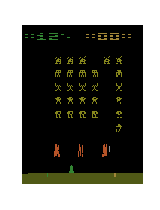
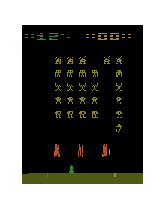
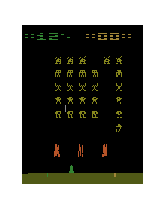
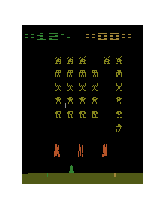
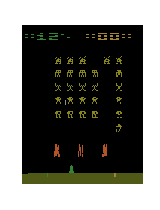
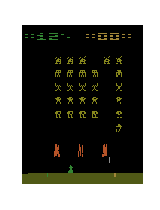
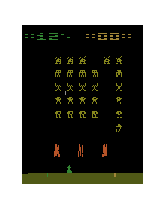
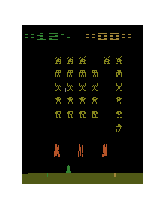
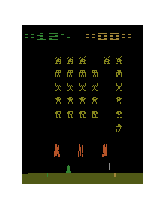
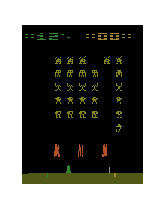
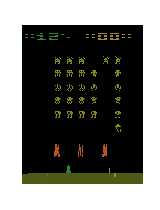
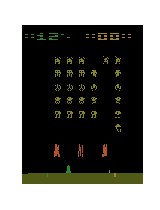
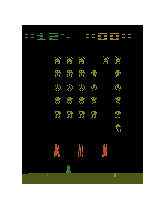
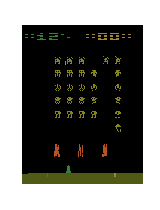
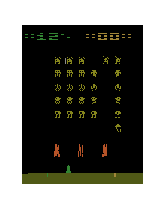
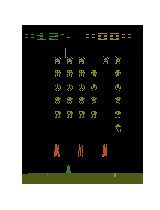
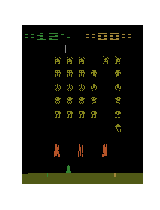
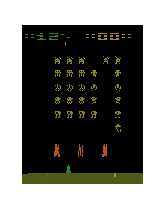
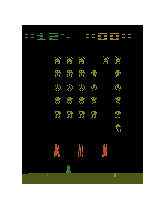
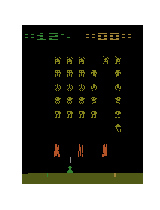
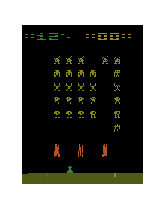
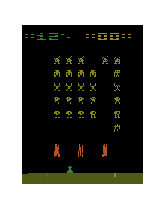
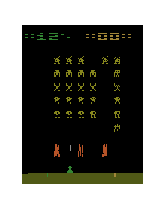
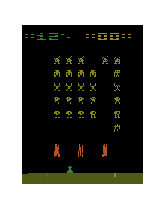
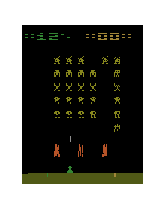
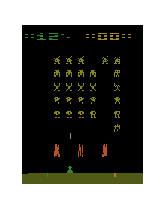
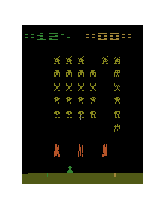
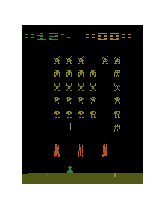
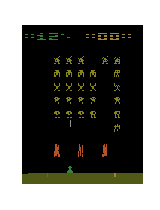
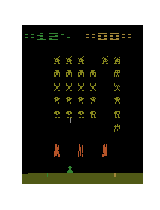
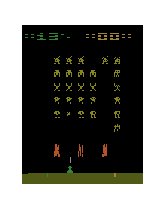
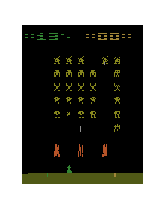
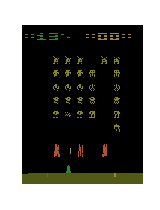
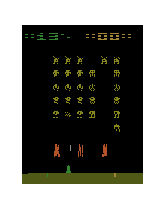
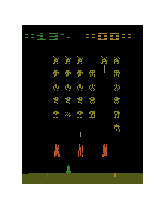
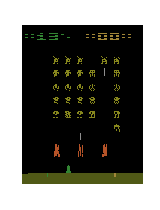
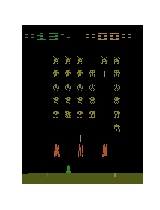
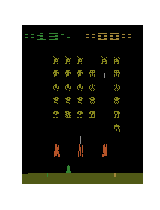
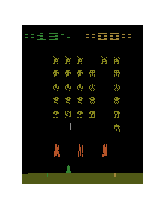
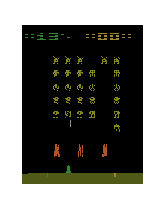
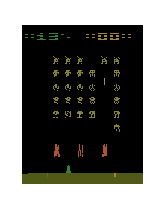
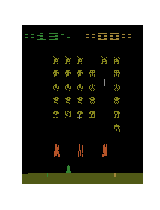
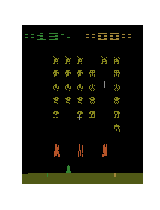
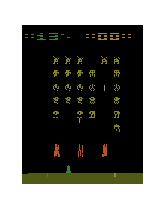
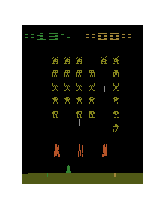
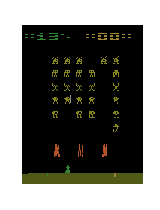
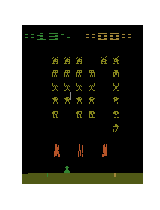
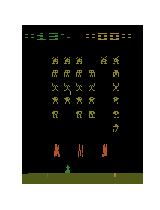
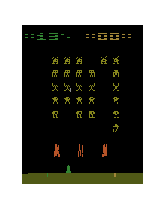
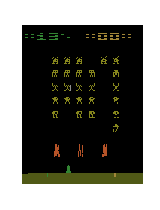
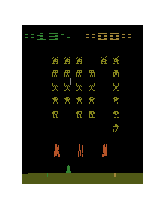
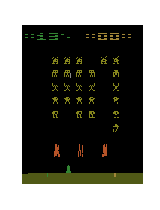
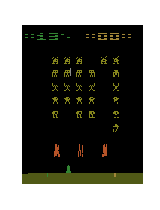
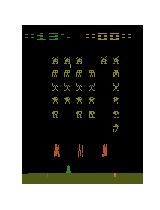
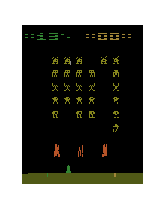
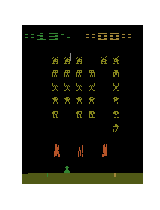
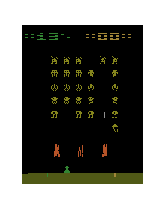
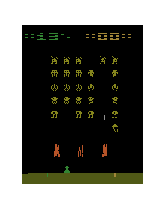
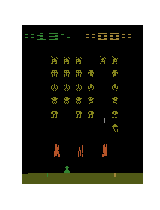
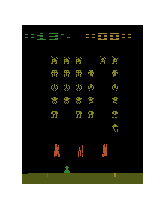
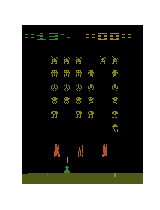
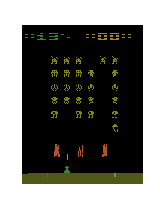
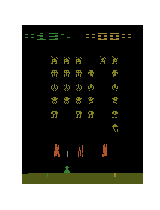
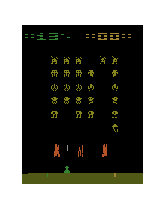
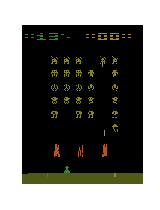
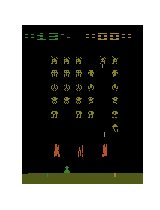
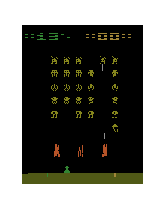
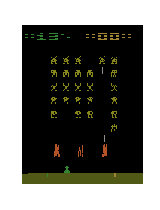
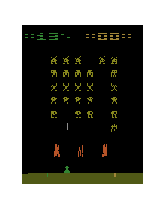
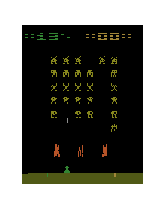
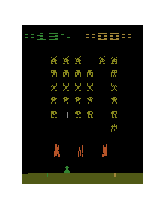
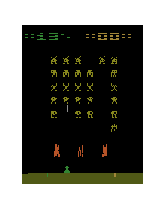
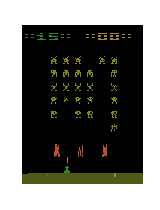
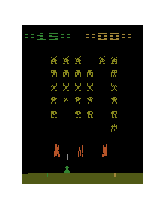
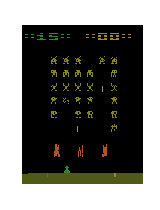
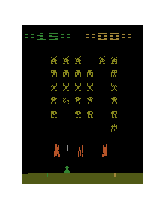
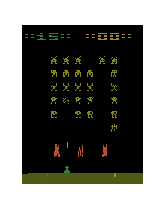
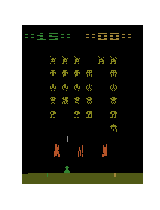
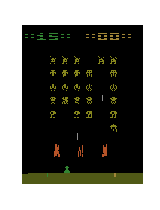
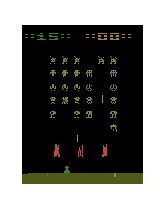
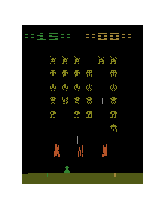
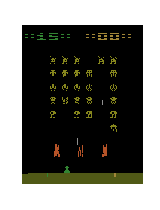
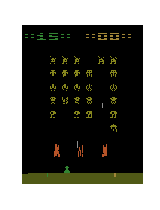
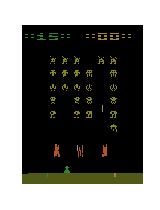
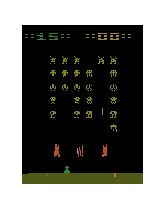
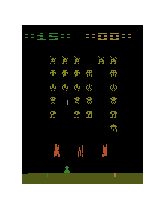
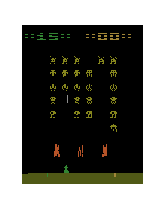
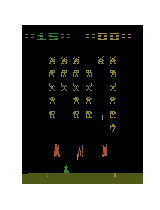
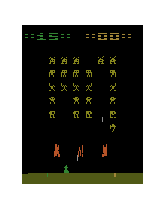
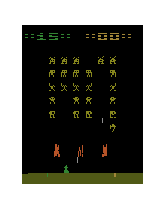
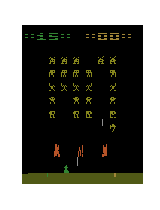
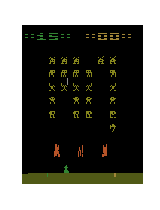
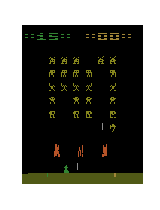
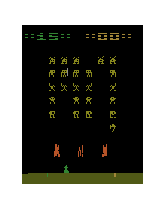
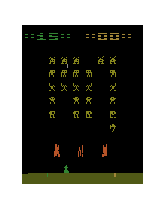
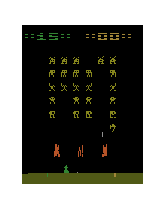
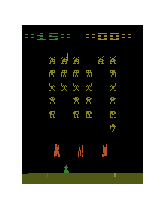
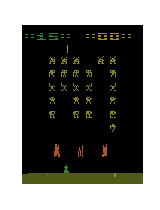
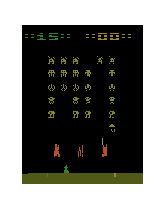
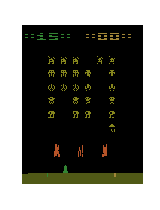
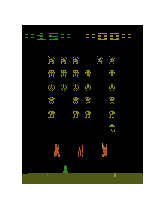
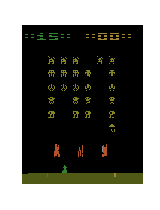
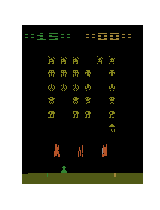
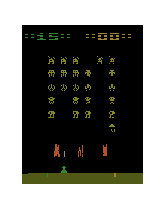
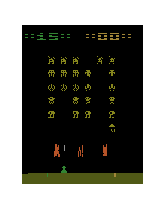
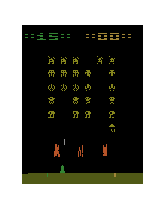
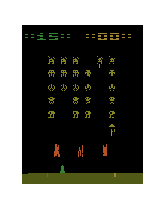
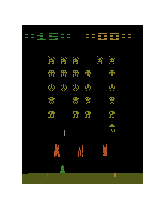
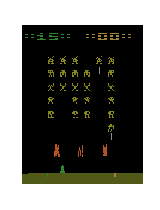
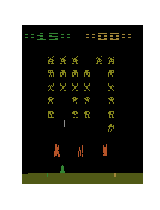
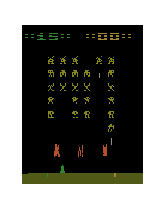
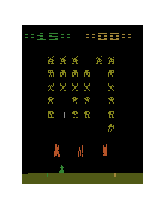
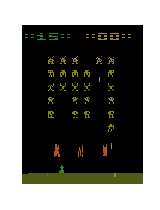
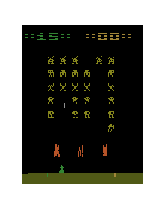
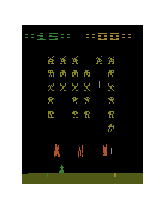
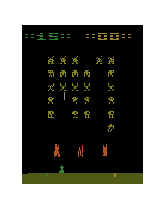
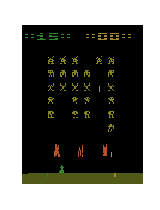
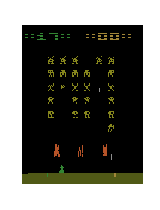
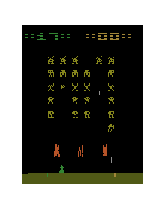
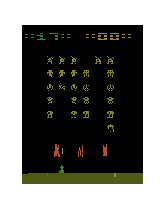
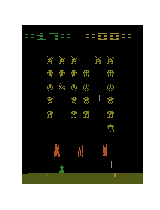
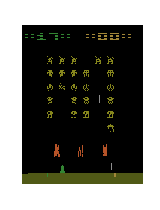
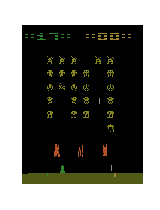
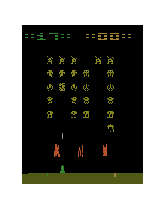
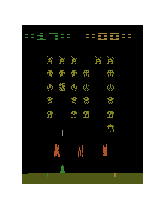
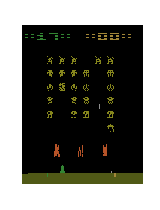
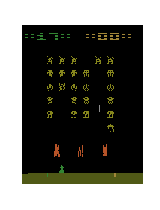
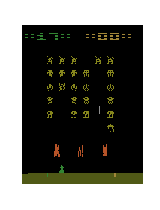
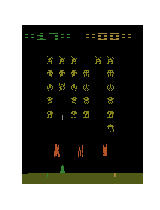
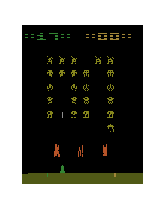
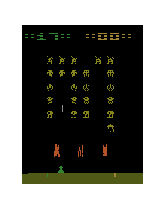
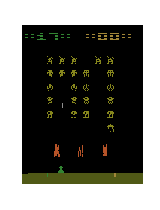
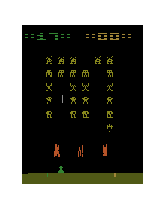
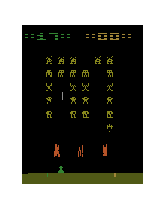
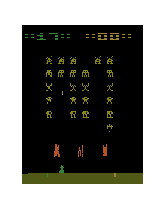
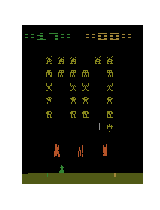
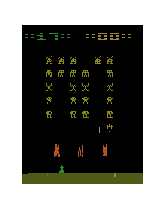
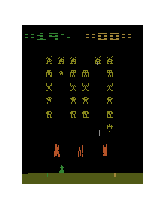
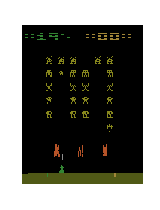
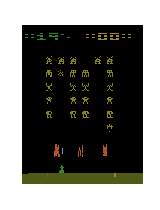
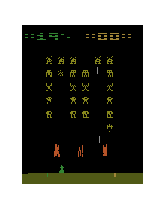
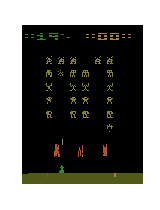
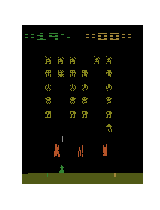
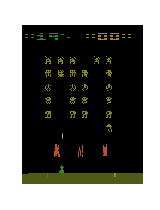
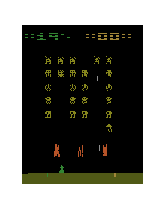
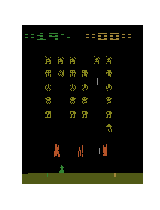
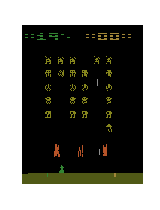
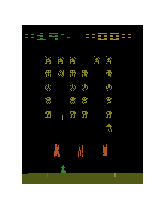
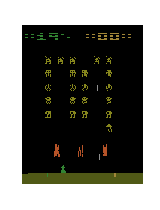
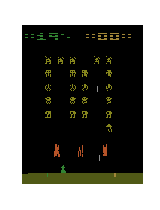
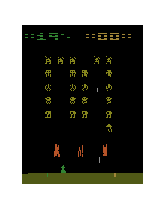
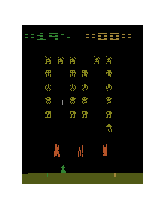
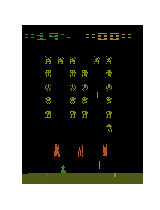
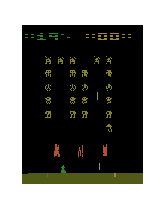
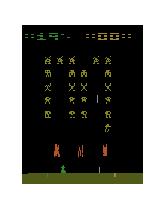
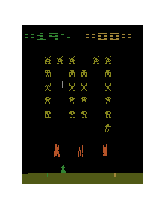
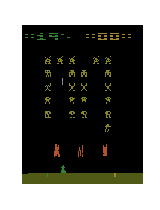
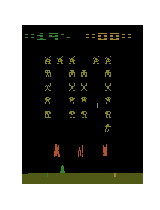
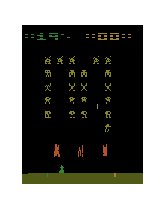
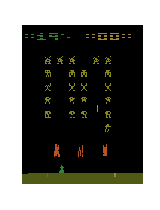
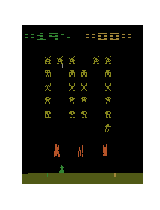
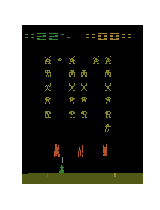
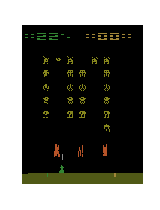
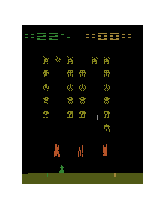
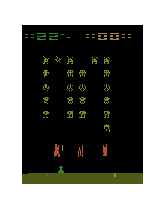
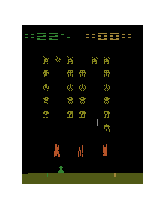
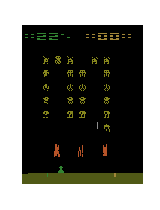
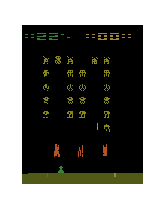
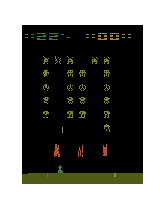
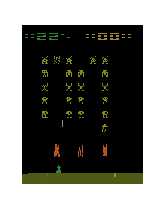
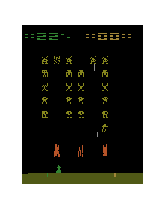
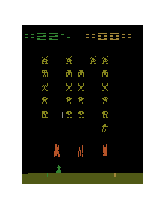
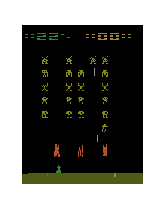
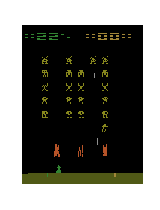
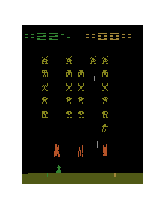
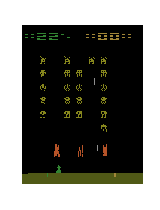
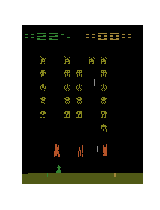
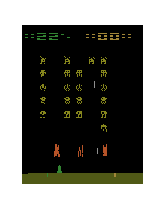
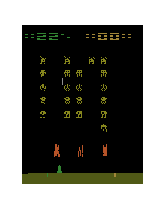
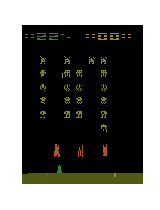
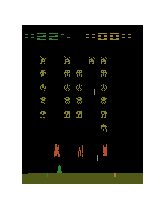
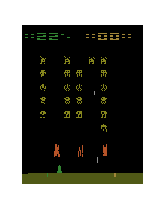
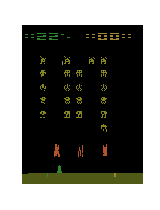
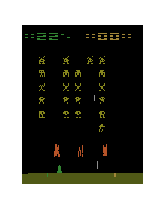
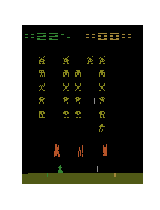
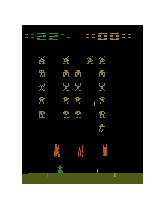
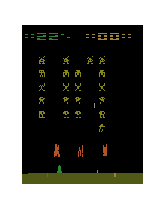
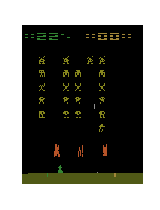
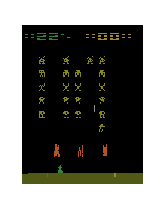
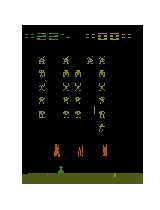
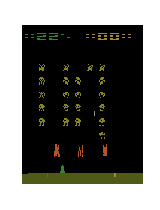
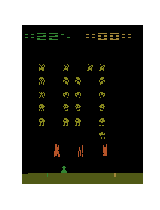
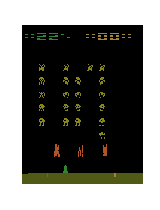
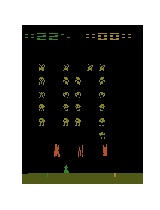
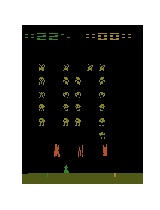
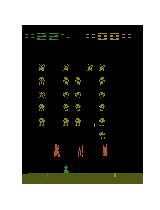
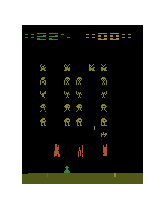
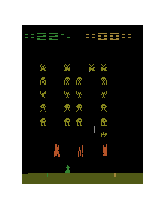
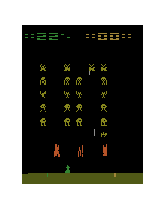
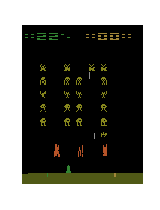
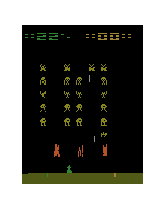
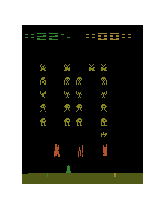
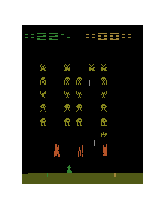
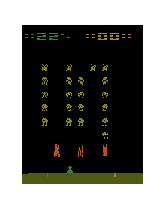
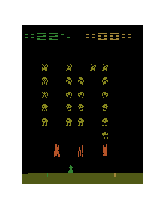
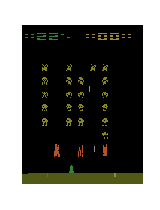
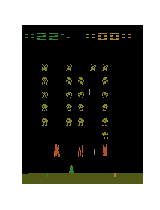
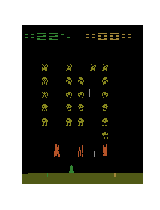
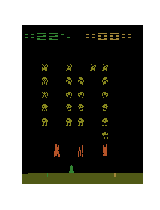
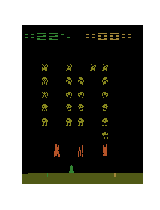
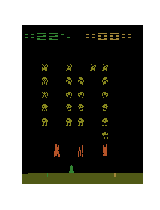
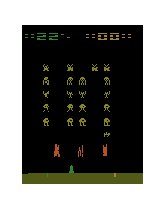
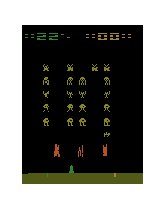
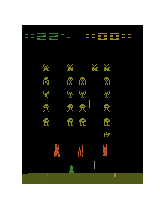
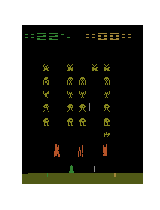
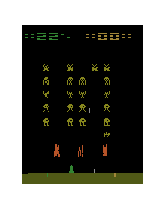
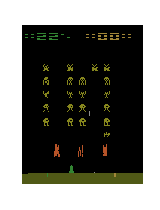
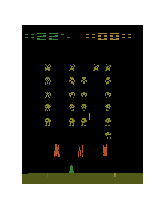
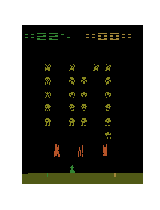
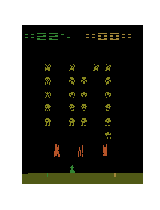
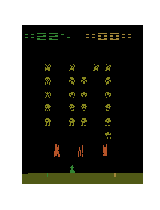
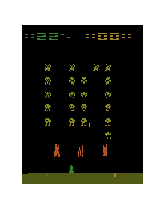
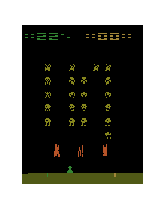
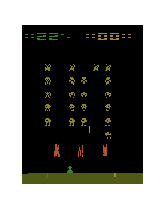
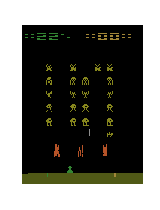
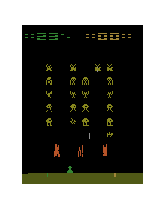
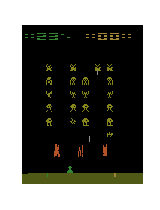
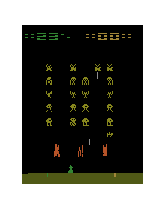
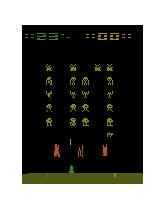
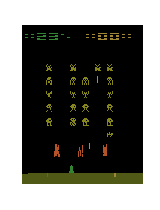
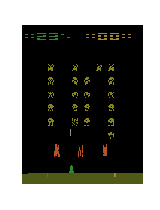
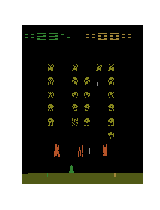
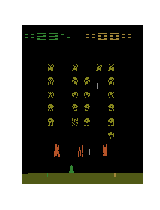
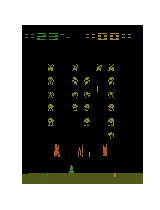
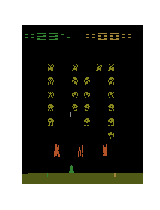
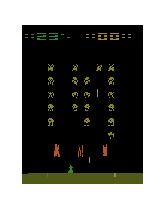
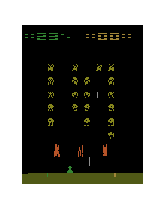
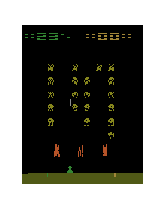
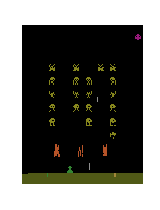
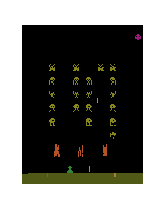
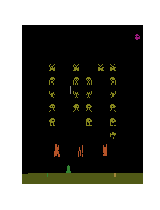
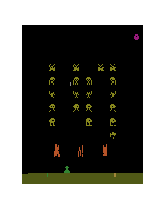
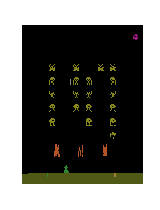
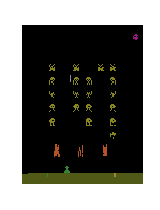
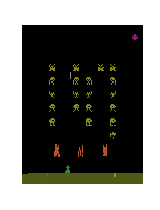
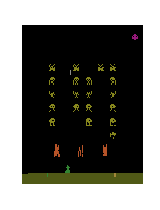
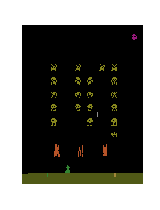
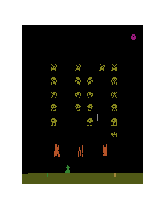
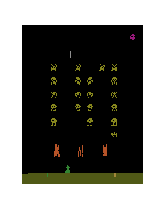
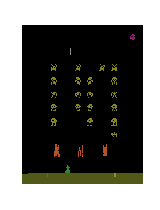
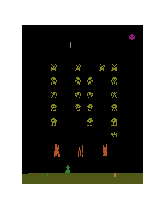
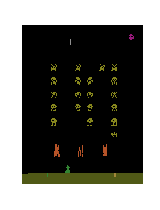
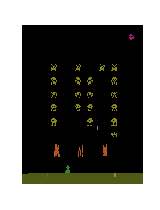
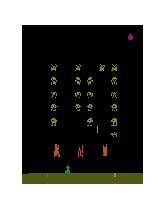
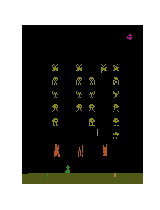
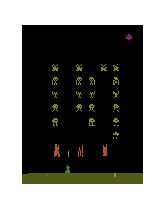
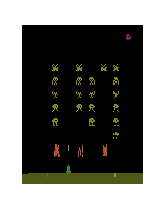
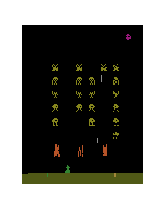
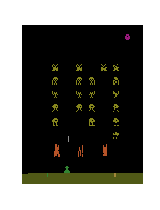
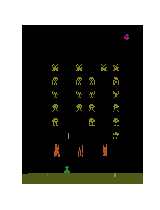
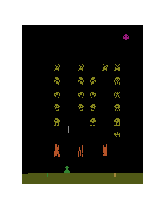
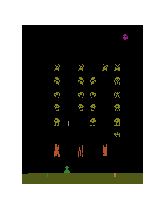
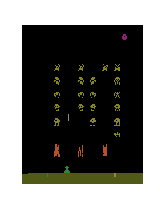
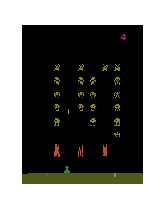
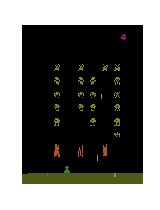
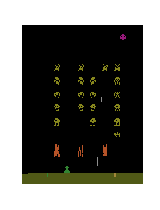
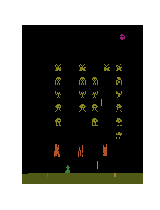
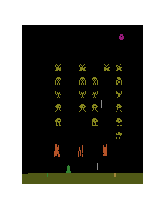
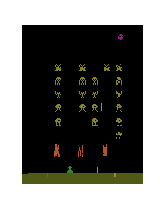
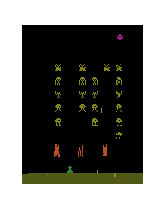
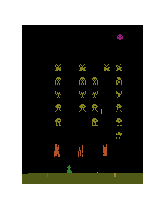
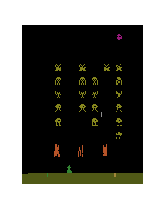
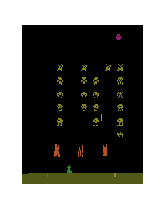
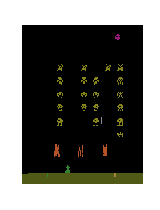
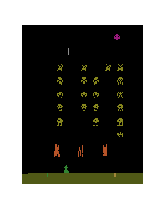
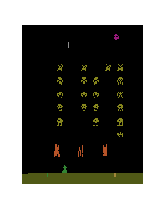
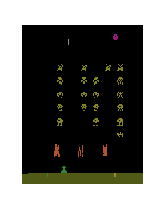
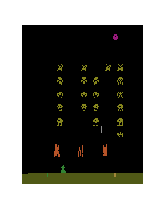
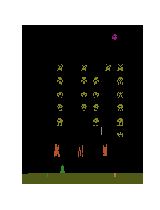
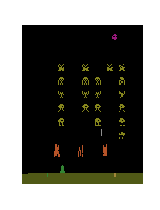
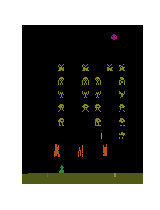
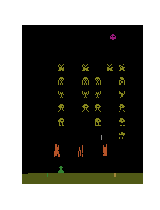
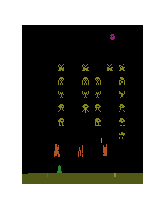
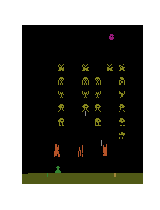
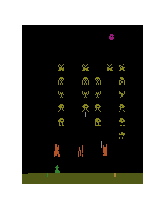
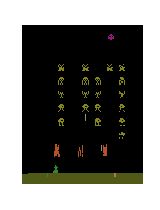
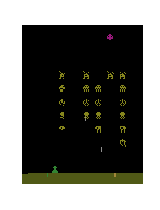
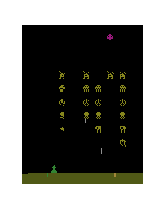
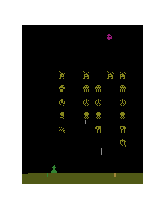
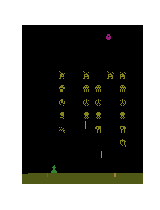
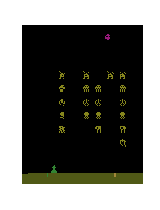
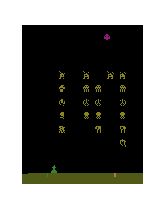
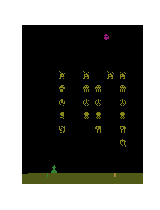
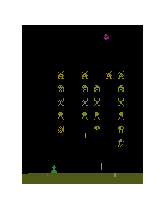
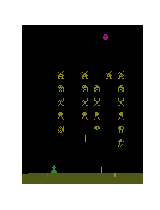
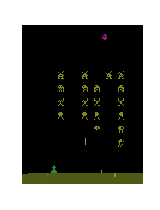
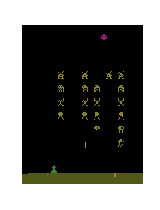
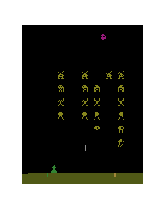
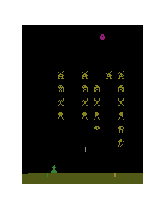
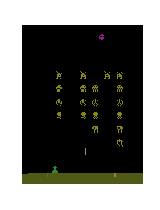
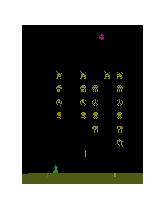
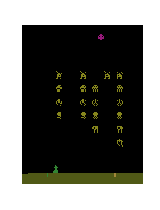
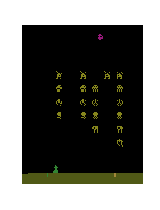
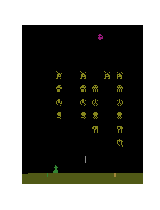
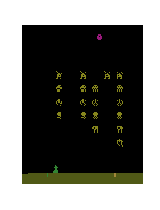
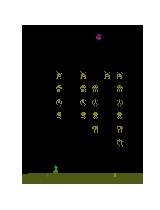
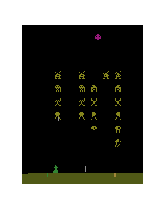
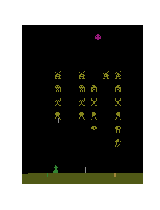
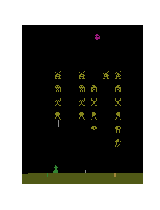
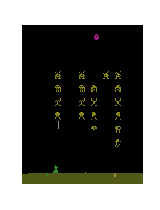
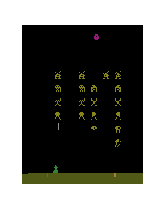
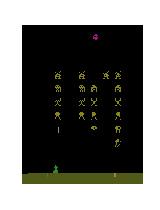
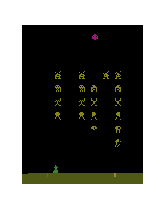
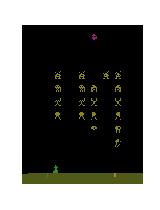
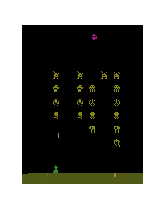
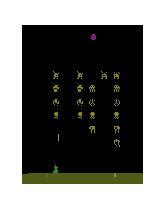
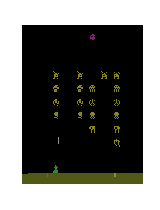
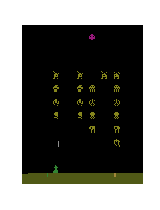
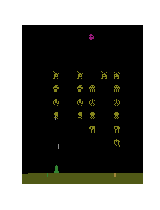
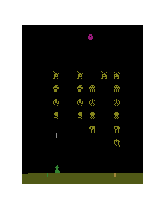
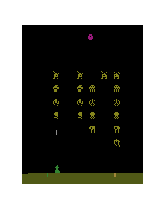
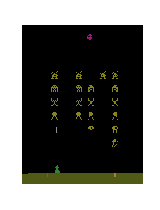
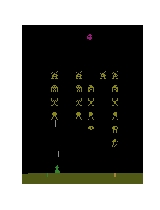
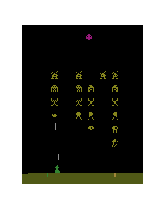
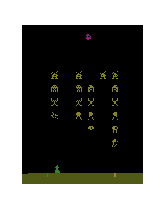
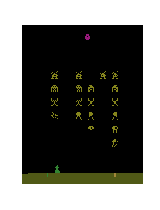
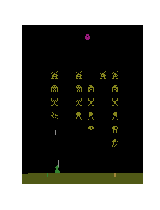
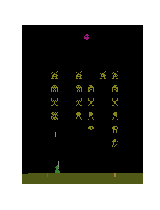
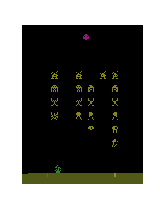
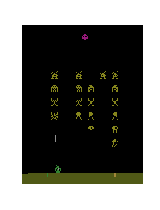
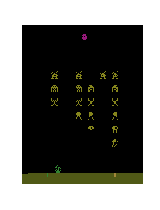
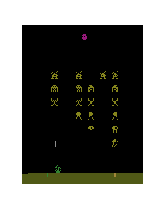
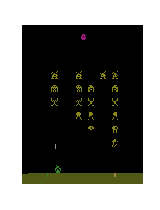
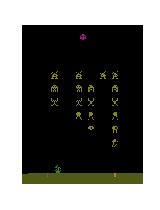
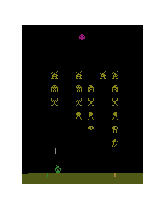
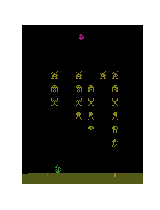
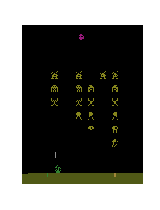
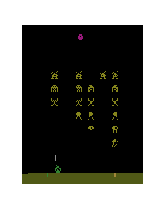
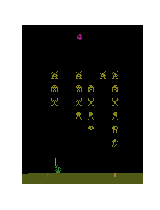
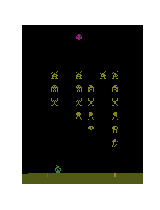
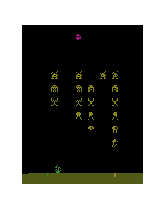
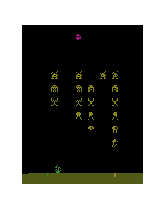
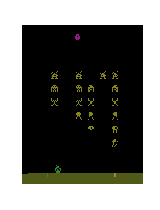
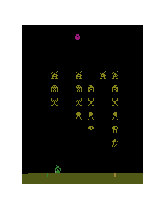
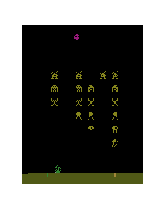
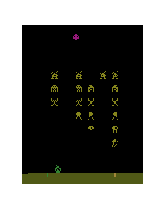
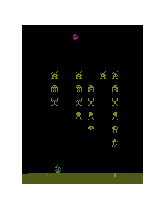
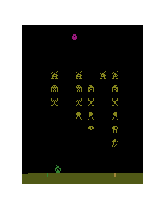
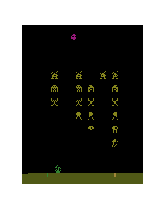
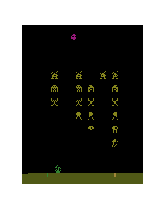
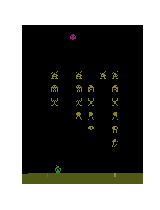
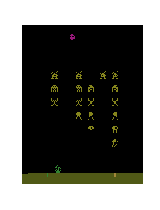
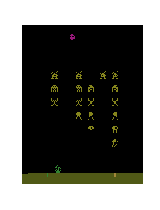
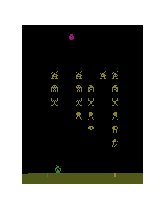
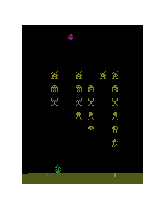
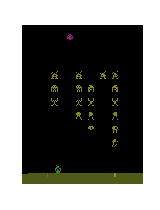
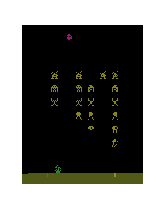
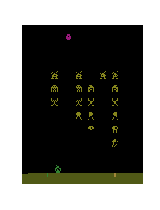
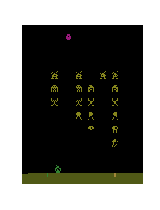
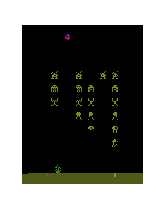
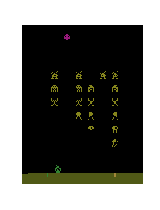
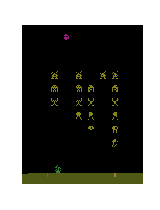
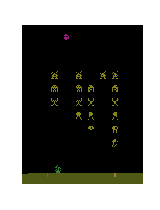
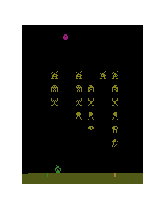
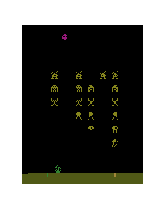
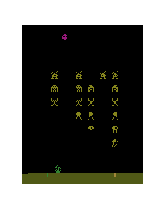
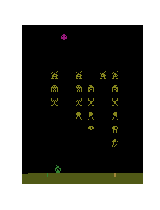
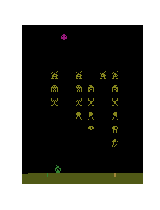
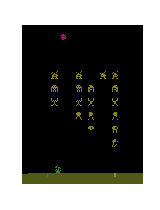
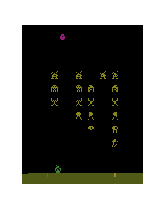
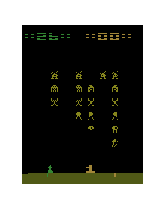
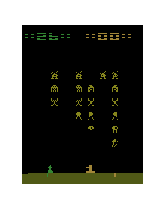
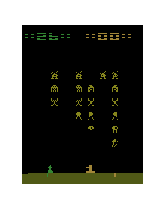
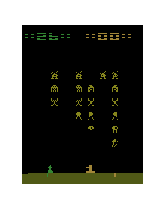
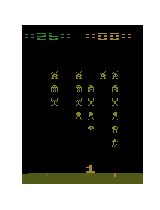
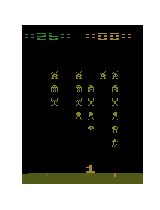
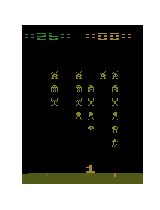
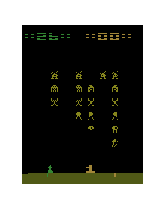
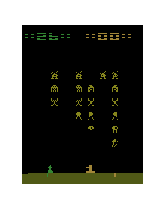
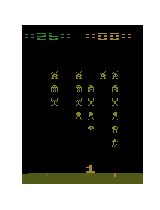
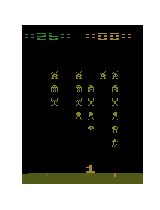
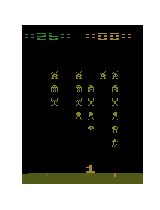
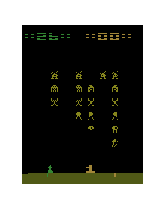
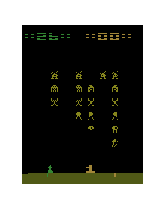
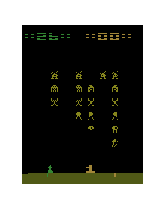
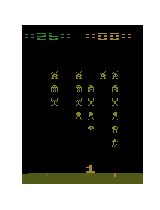
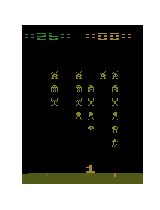
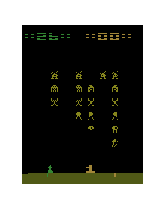
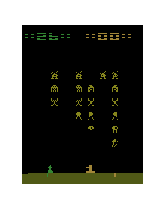
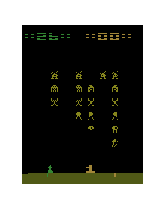
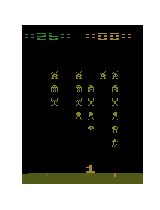
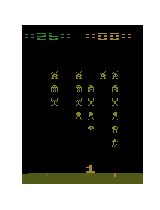
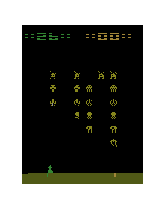
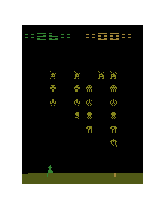
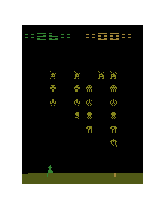
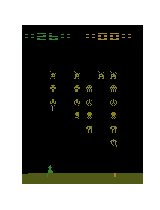
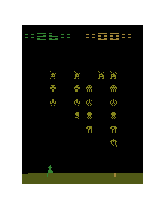
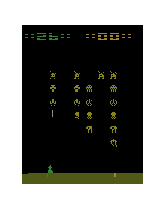
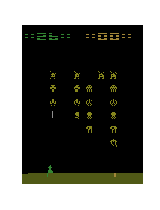
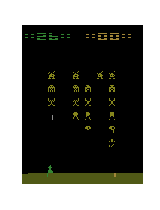
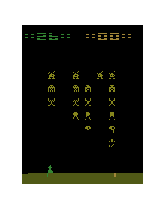
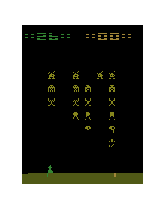
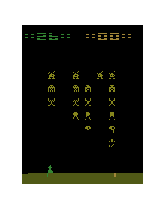
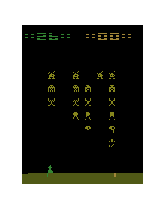
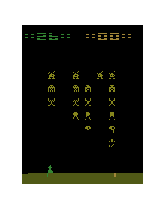
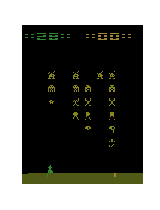
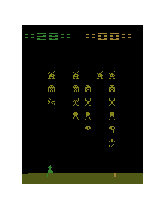
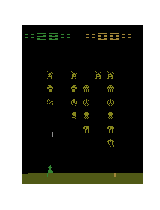
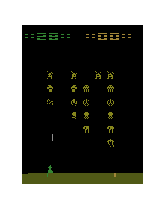
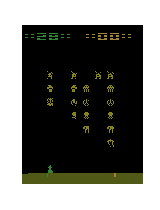
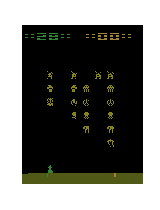
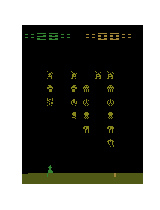
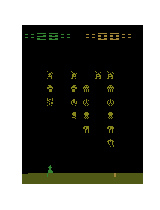
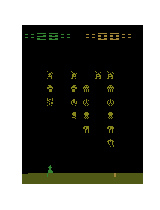
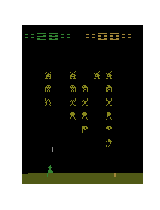
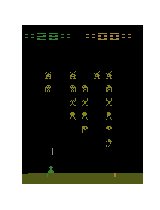
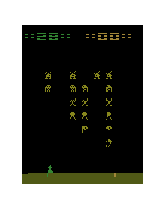
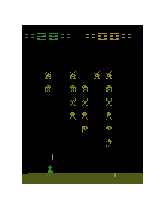
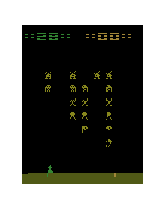
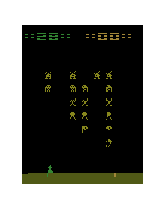
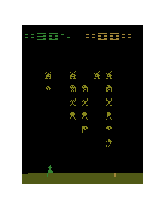
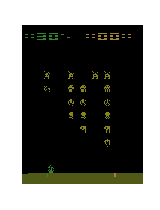
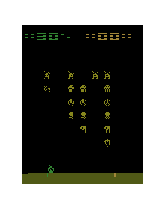
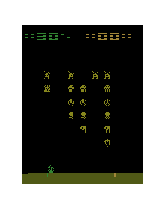
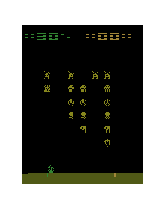
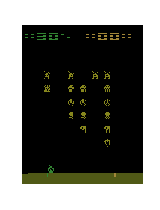
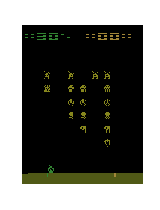
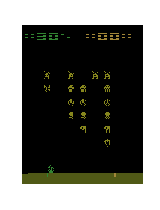
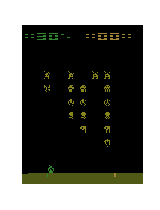
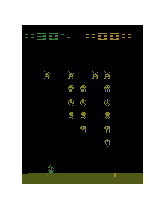
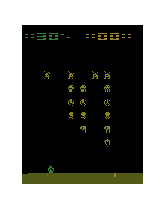
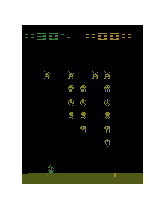
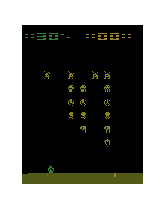
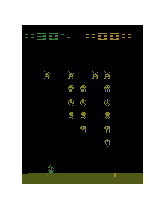
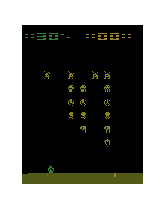
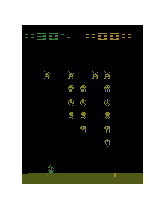
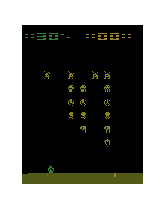
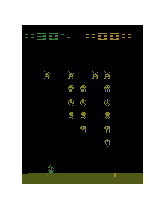
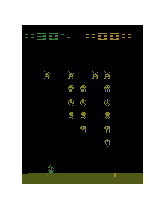
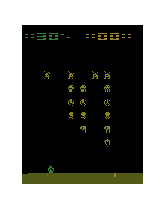
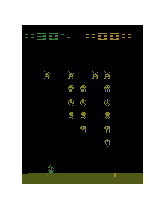
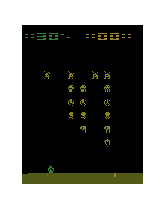
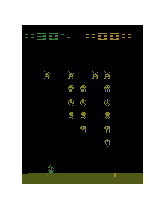
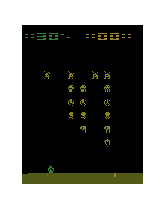
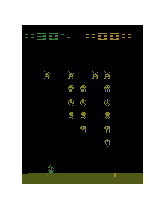
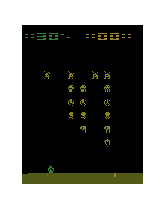
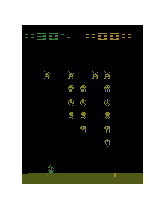
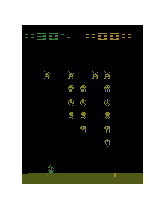
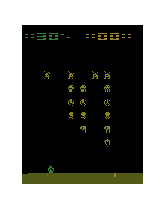
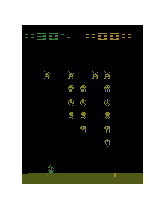
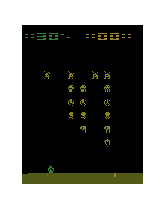
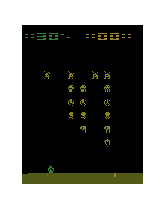
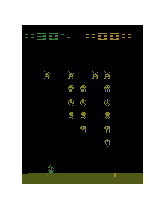
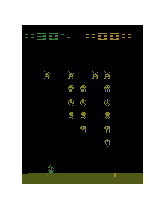
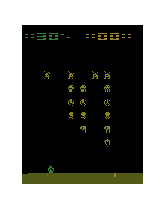
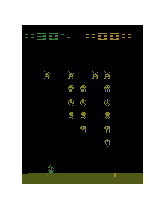
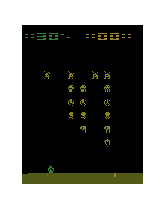
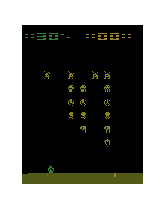
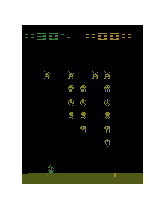
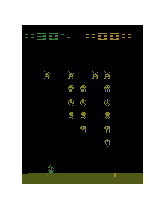
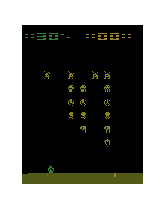
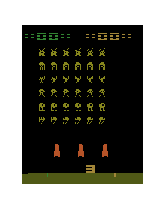
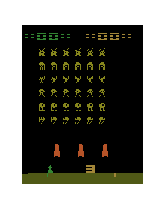
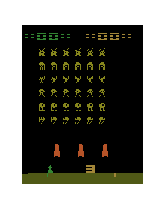
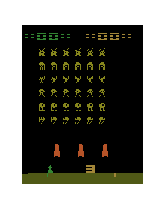
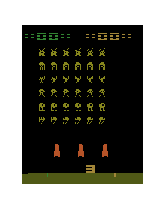
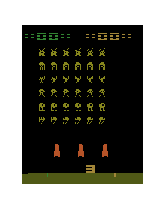
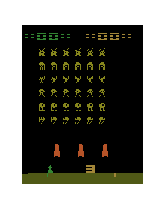
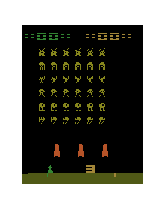
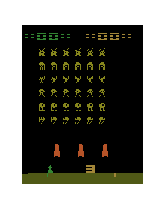
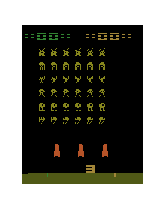
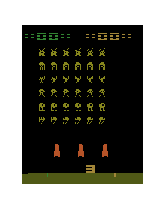
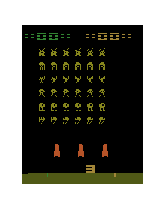
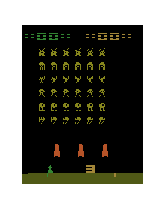
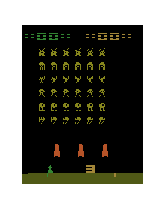
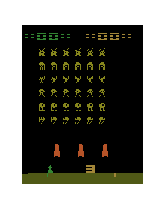
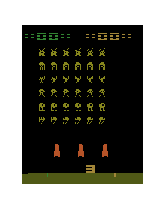
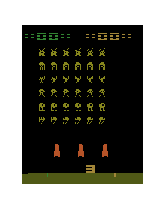
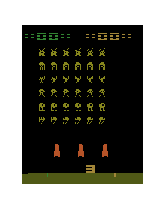
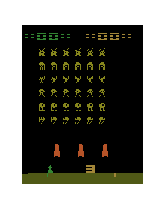
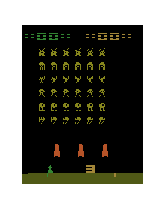
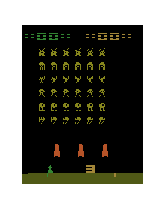
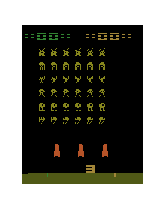
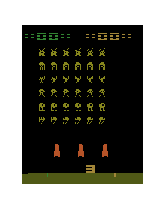
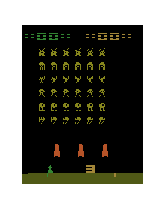
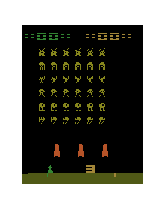
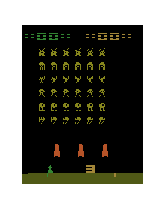
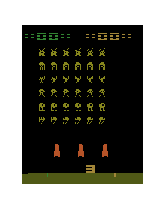
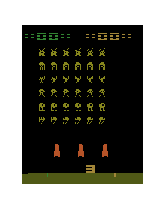
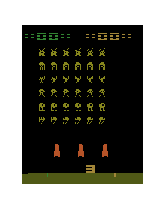
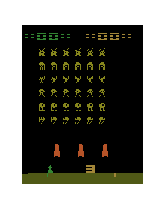
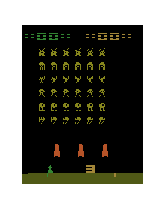
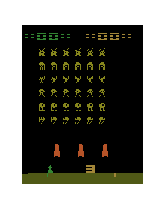
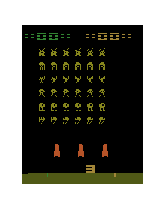
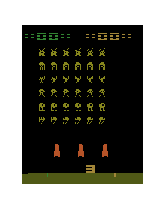
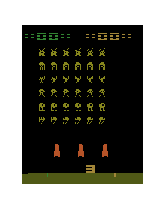
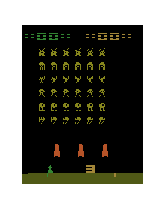
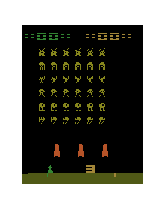
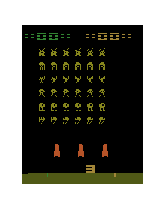
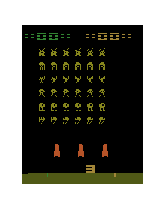
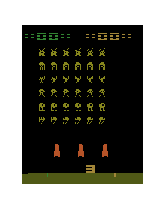
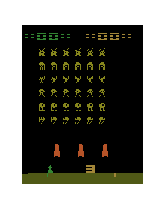
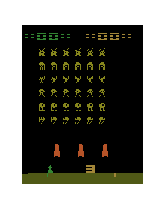
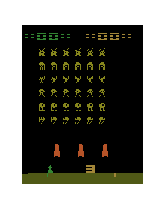
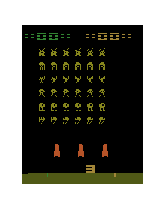
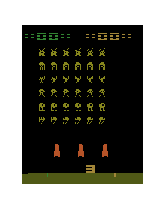
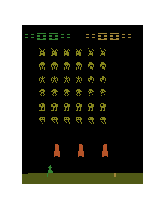
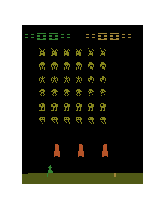
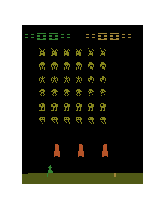
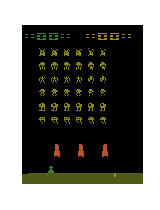
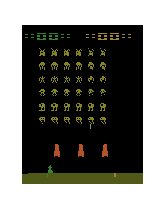
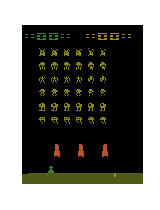
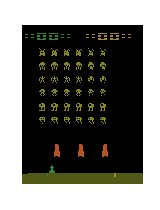
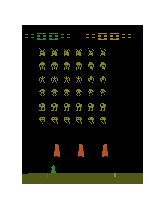
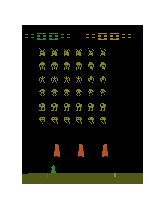
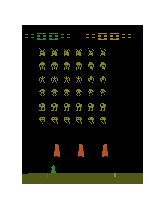
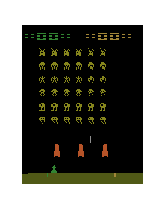
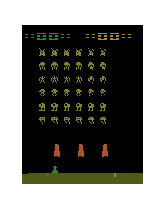
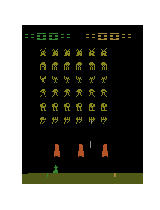
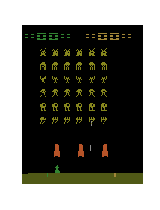
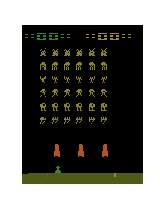
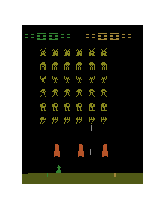
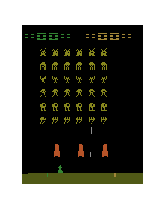
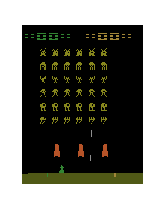
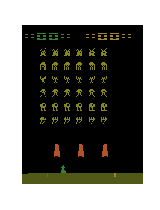
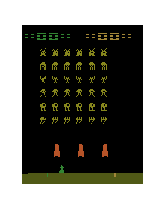
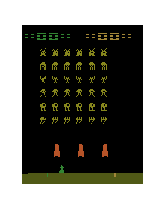
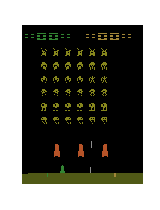
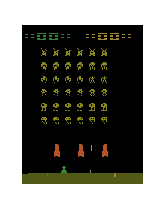
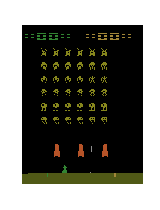
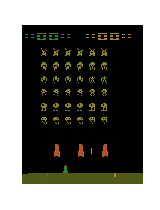
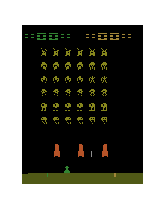
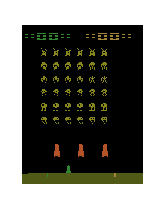
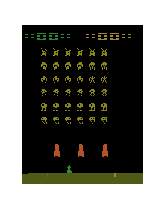
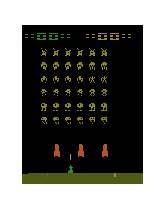
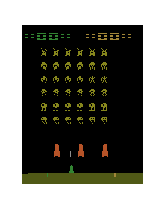
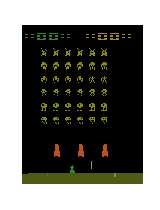
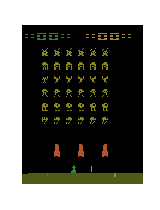
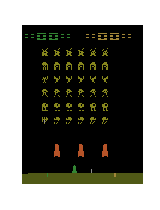
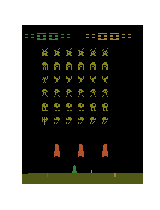
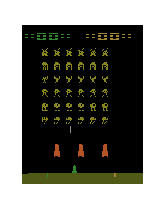
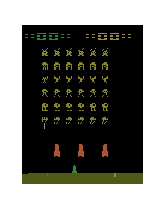
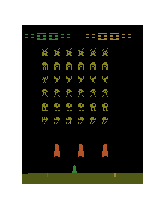
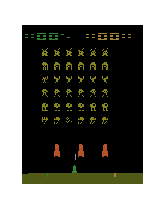
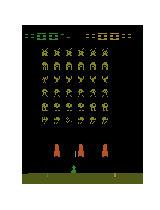
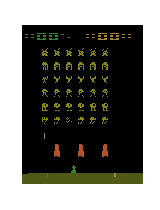
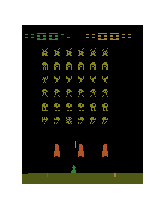
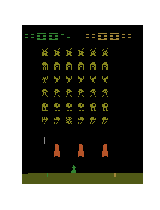
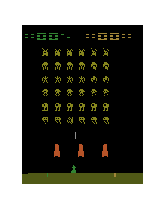
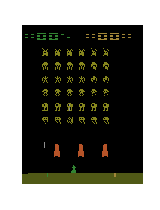
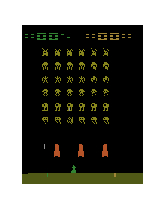
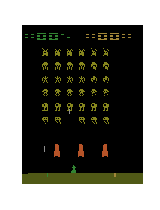
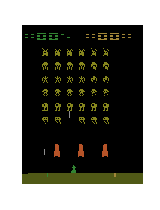
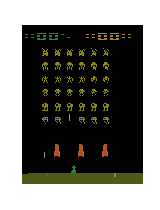
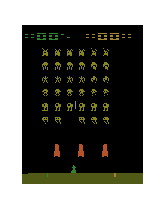
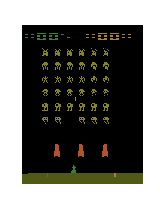
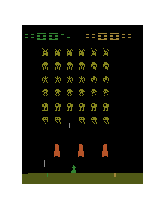
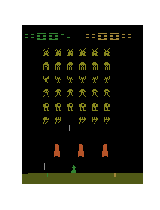
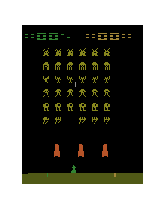
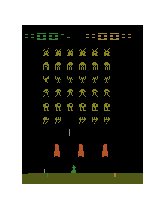
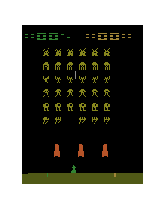
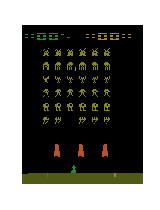
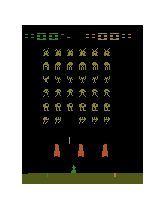
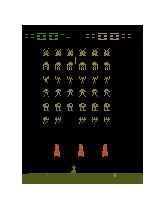
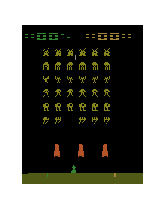
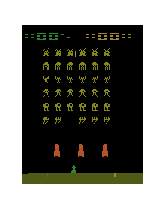
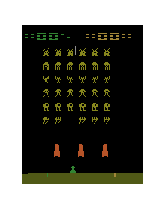
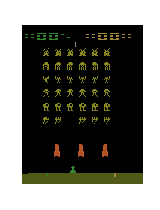
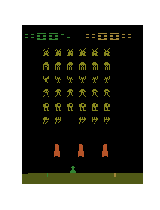
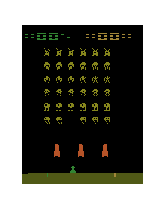
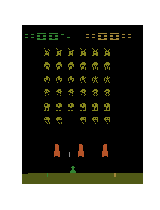
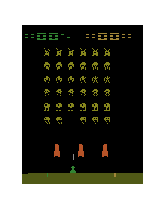
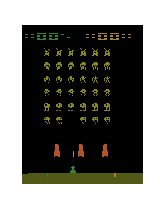
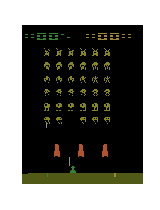
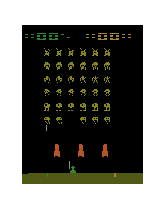
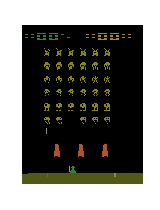
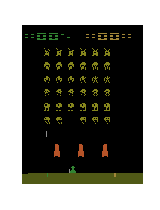
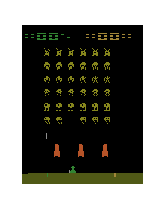
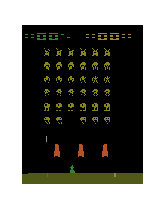
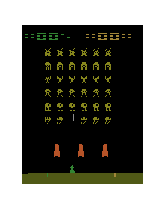
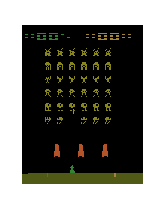
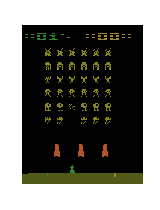
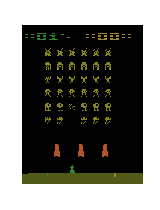
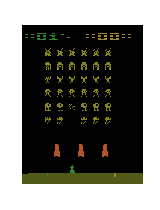
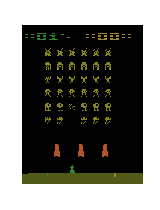
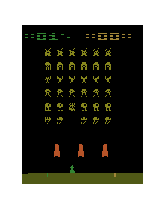
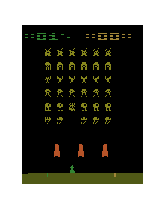
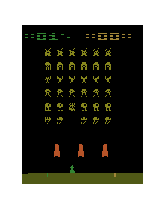
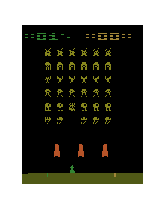
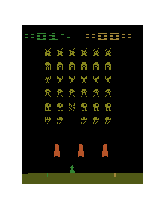
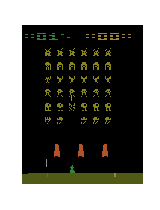
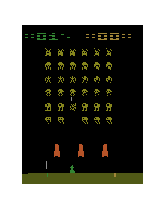
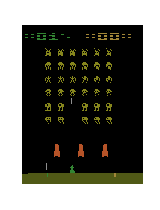
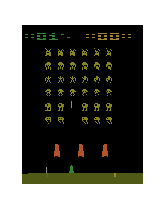
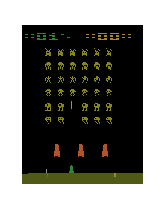
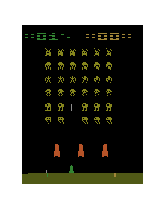
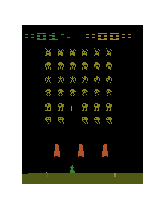
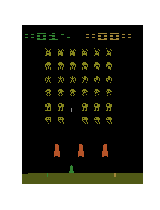
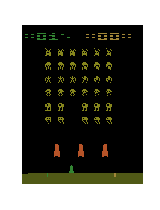
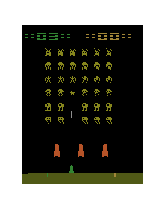
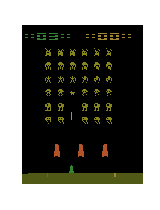
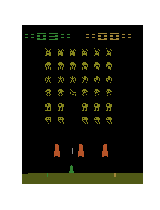
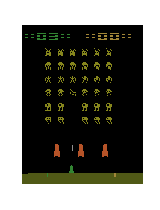
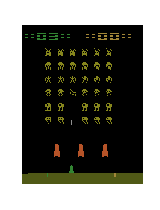
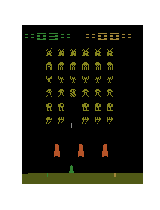
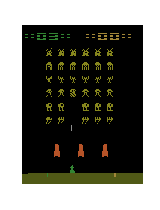
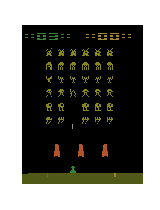
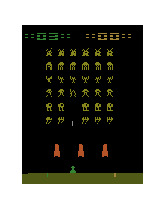
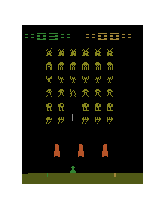
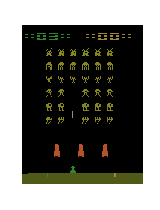
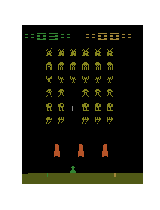
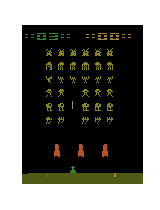
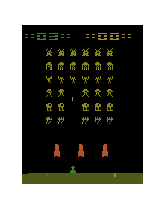
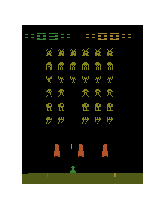
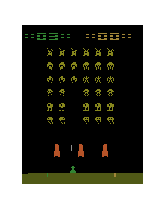
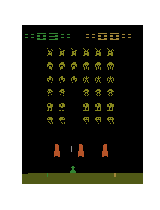
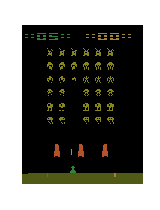
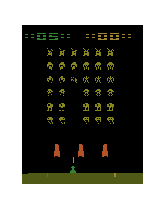
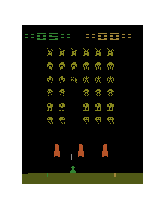
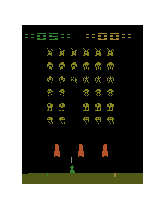
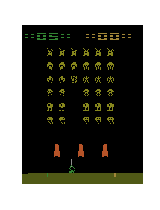
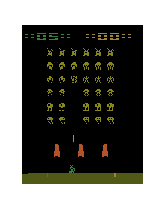
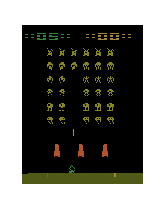
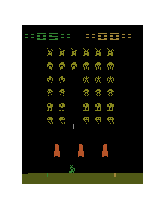
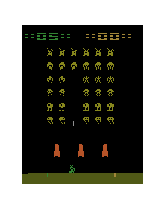
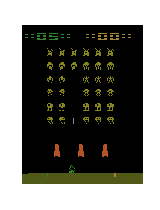
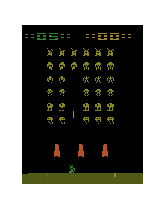
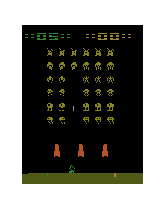
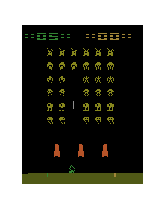
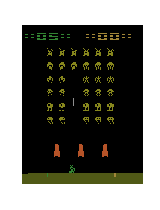
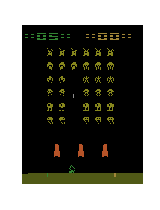
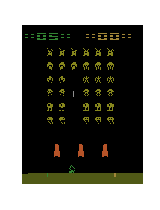
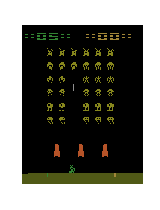
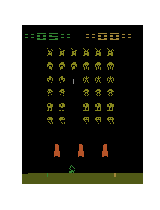
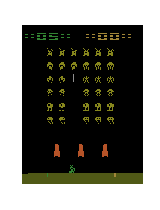
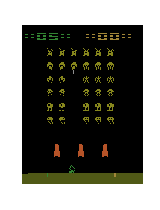
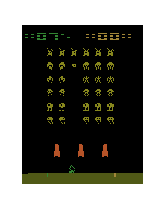
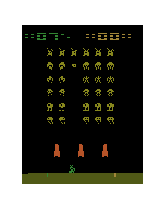
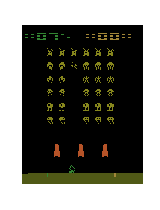
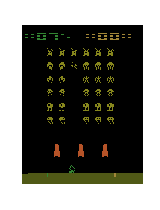
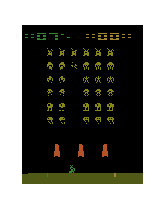
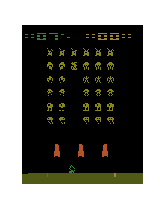
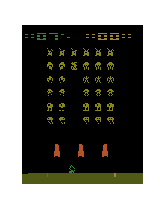
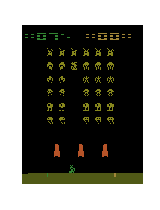
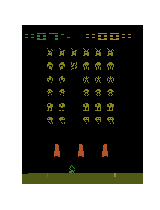
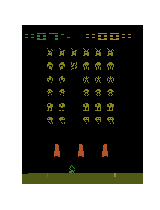
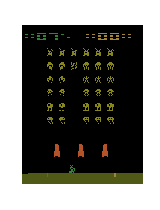
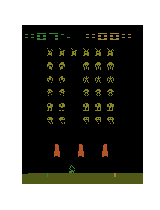
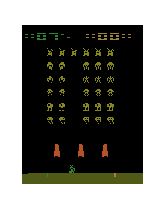
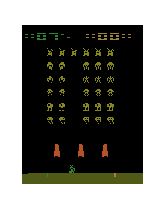

In [3]:
def display_frames_as_gif(frames, filename_gif = None):
    """
    Displays a list of frames as a gif, with controls
    """
    plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi = 72)
    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=50)
    if filename_gif: 
        anim.save(filename_gif, writer = 'imagemagick', fps=20)
    display(display_animation(anim, default_mode='loop'))

    
frameshistory = []
observation = env.reset()
backupepsilon = brain.epsilon

brain.epsilon = 0.2

for _ in range(1500):
    action = brain.getAction()
    
    actionmax = np.argmax(np.array(action))
    
    nextObservation,reward,terminal, info = env.step(actionmax)
    if terminal:
        nextObservation = env.reset()
    frameshistory.append(nextObservation)
    nextObservation = preprocess(nextObservation)
    brain.setPerception(nextObservation,action,reward,terminal)
brain.epsilon = backupepsilon
    
display_frames_as_gif(frameshistory, 'playing_space_invaders_DO.gif')

![Playing space invaders](http://www.pinchofintelligence.com/wp-content/uploads/2017/07/playing_space_invaders.gif)